# Graphs

In this jupyter notebook the necessary code to run the graphs will be found. 

## Imports

The code snippet sets up an environment for network analysis and visualization by installing necessary libraries (`matplotlib` and `scapy`) and importing essential modules for data handling, plotting, and network packet manipulation. It imports standard libraries such as `ast`, `ipaddress`, `json`, `numpy`, `pandas`, and `re`, as well as custom modules for specialized packet headers (`EPHeader`) and routing information (`MRI`). Additionally, it configures a colormap (`Set2`) from `matplotlib` for consistent and visually appealing plots. 

In [1]:
!pip install matplotlib
!pip3 install scapy

import ast
import ipaddress
import json
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import pandas as pd
import re
from io import StringIO
from scapy.all import *
from time import sleep
from utils.EPHeader import *
from utils.MRI import *
import pandas as pd
from scapy.all import Ether
import numpy as np
cmap = plt.get_cmap('Set2')

## Experiments 1-8 graphs

### Bandwidth

In [2]:
experiments = {"exp1" : None, "exp2" : None, "exp3" : None, "exp4" : None, "exp5" : None, "exp6" : None, "exp7" : None, "exp8" : None}
for experiment in experiments:
    with open(f'./graphs/data/{experiment}.json') as f:
        data = json.load(f)
    intervals = data['intervals']
    times = []

    for i in range(30):
        times.append(i+1)

    iperf_bandwidth = []
    for i in range(5):
        iperf_bandwidth.append(0)

    for interval in enumerate(intervals):
        iperf_bandwidth.append(interval[1]['sum']['bits_per_second'])

    n = 10 if experiment == 'exp1' or experiment == 'exp2' or experiment == 'exp3' or experiment == 'exp4' else 15
    for i in range(n):
        iperf_bandwidth.append(0)
    data = {
        'times': times,
        'iperf_bandwidth': iperf_bandwidth,
    }
    experiments[experiment] =  pd.DataFrame(data)
    
MRI_bandwidth = []
for i in range(30):
    MRI_bandwidth.append(544)

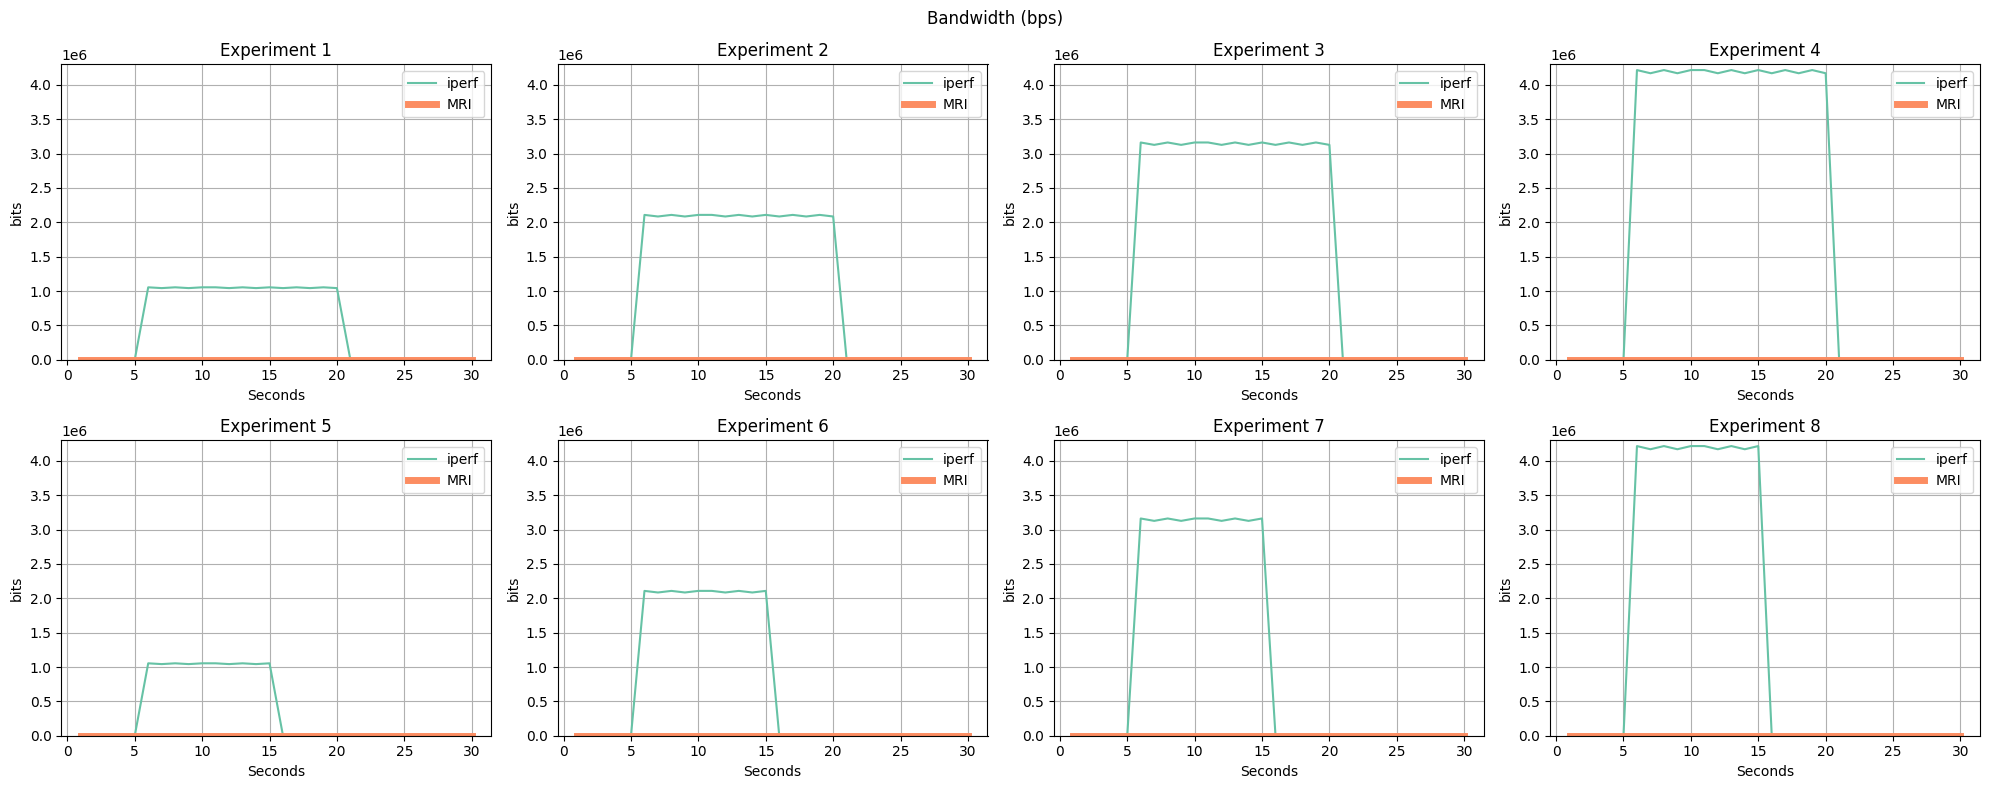

In [3]:
plt.figure(figsize=(20, 8))

for n in range(1,9):
    plt.subplot(2,4,n)
    result_df = experiments[f"exp{n}"]
    plt.plot(result_df["times"], result_df["iperf_bandwidth"], linestyle='-', color=cmap(0),label="iperf")
    plt.plot(result_df["times"], MRI_bandwidth, linestyle='-', color=cmap(1), linewidth=5,label="MRI") 
    plt.title(f'Experiment {n}')
    plt.xlabel('Seconds')
    plt.ylabel('bits')
    plt.ylim([0, 4.3e6])
    plt.legend()
    plt.grid(True)

plt.suptitle('Bandwidth (bps)')
plt.tight_layout()
plt.savefig('./graphs/figures/BW_exp0.png')
plt.show()

### Number of packets in the buffer of each switch

In [4]:
experiments = {"exp1" : None, "exp2" : None, "exp3" : None, "exp4" : None, "exp5" : None, "exp6" : None, "exp7" : None, "exp8" : None}
max_buffer1 = 100
max_buffer2 = 100

for experiment in experiments:
    df = pd.read_csv(f'./graphs/data/{experiment}.csv')
    hex_list = df['Values'].tolist()
    packet_numbers = [int(packet[-2:], 16) for packet in hex_list]
    max_value = max(packet_numbers)
    sorted_array = [-1] * (max_value + 1)
    for number in packet_numbers:
        sorted_array[number] = number
    qdepth_values_swid_1 = [max_buffer1 if x == -1 else None for x in sorted_array]
    #qdepth_values_swid_2 = [None for x in sorted_array]
    qdepth_values_swid_2 = [0 if x == -1 else None for x in sorted_array]
    #qdepth_values_swid_2 = [max_buffer2 if x == -1 else None for x in sorted_array]
    for index, pkt in enumerate(hex_list):
        if sorted_array[int(pkt[-2:], 16)] != -1:
            packet_bytes = bytes.fromhex(pkt)
            packet_reconstructed = Ether(packet_bytes)
            mri_layer = packet_reconstructed.getlayer(IPOption_MRI)
            qdepth_value_swid_1 = None
            qdepth_value_swid_2 = None
            if mri_layer:
                for sw_trace in mri_layer.swtraces:
                    if sw_trace.swid == 1:
                        qdepth_value_swid_1 = sw_trace.qdepth
                    elif sw_trace.swid == 2:
                        qdepth_value_swid_2 = sw_trace.qdepth
    
            if qdepth_value_swid_1 is not None:
                qdepth_values_swid_1[int(pkt[-2:], 16)] = qdepth_value_swid_1
            #if qdepth_value_swid_2 is not None:
                qdepth_values_swid_2[int(pkt[-2:], 16)] = qdepth_value_swid_2
    data = {
        'QDepth_SWID_1': qdepth_values_swid_1,
        'QDepth_SWID_2': qdepth_values_swid_2,
        'sorted_array': sorted_array,
    }
    
    experiments[experiment] =  pd.DataFrame(data)

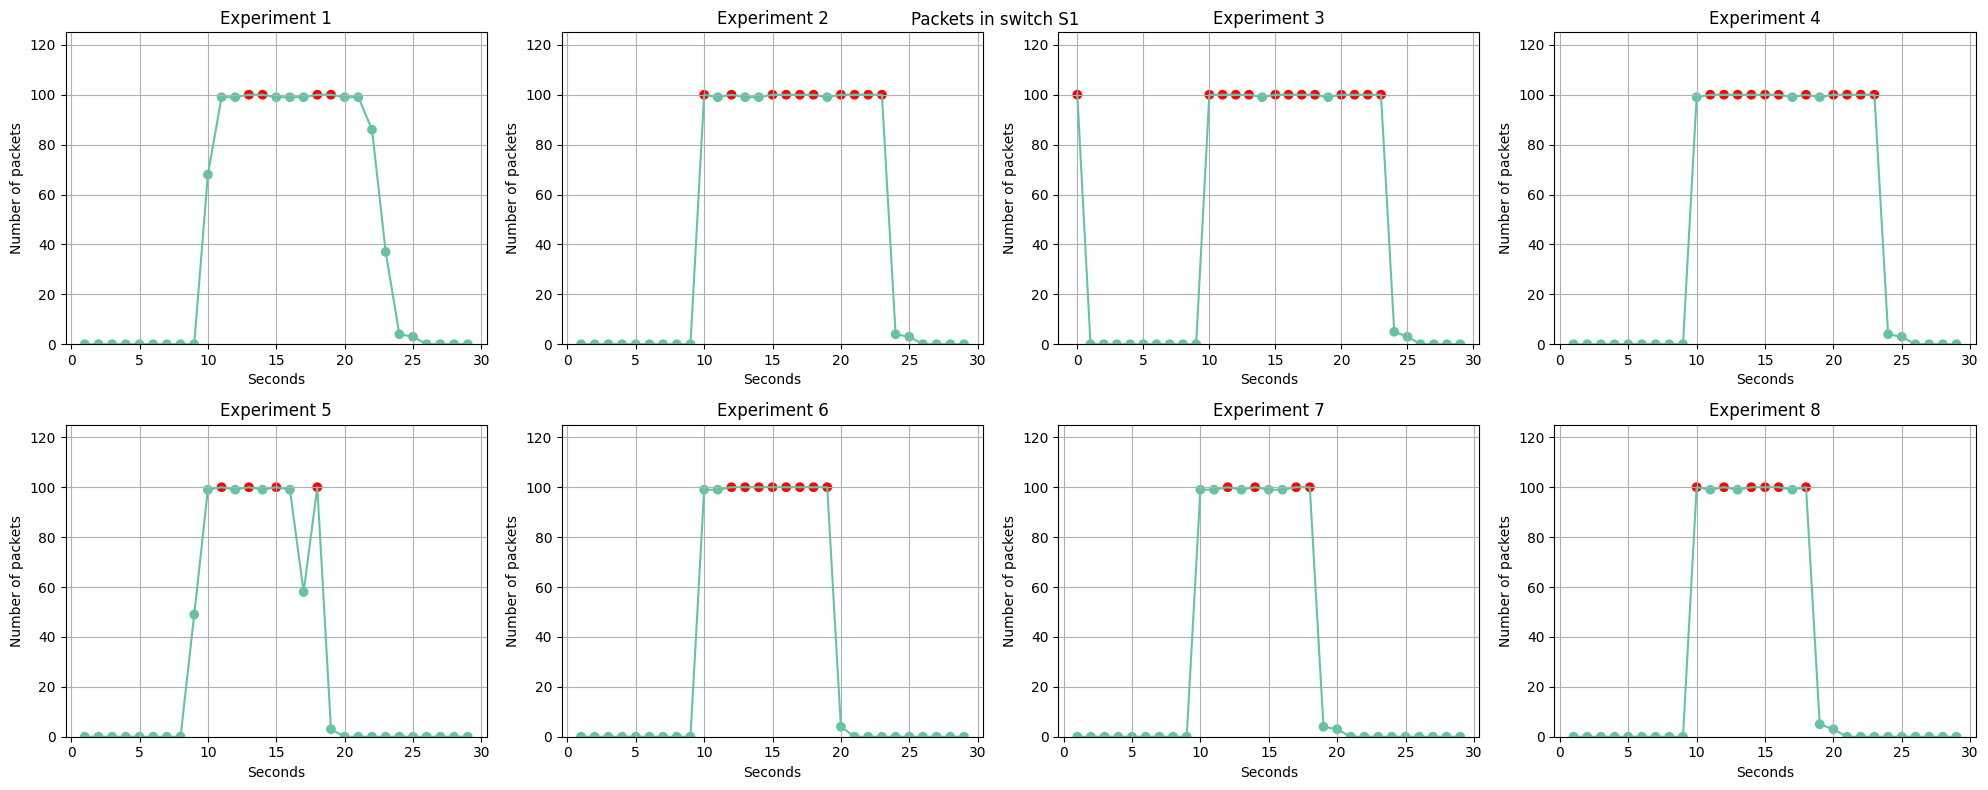

In [5]:
plt.figure(figsize=(20, 8))
swidSwitch = "QDepth_SWID_1"

plt.subplot(2,4,1)
result_df = experiments["exp1"][1:]
colors = ["red" if val == -1 else cmap(0) for val in result_df['sorted_array']]
packet_numbers = result_df.index
plt.plot(packet_numbers, result_df[f'{swidSwitch}'], label=f'{swidSwitch}',color=cmap(0))
plt.scatter(packet_numbers, result_df[f'{swidSwitch}'], c=colors, label=f'{swidSwitch}', marker='o')
plt.xlabel('Seconds')
plt.ylabel('Number of packets')
plt.title('Experiment 1')
plt.ylim([0, int(max_buffer1)+25])
plt.grid(True)

plt.subplot(2,4,2)
result_df = experiments["exp2"][1:]
colors = ["red" if val == -1 else cmap(0) for val in result_df['sorted_array']]
packet_numbers = result_df.index
plt.scatter(packet_numbers, result_df[f'{swidSwitch}'], c=colors, label=f'{swidSwitch}', marker='o')
plt.plot(packet_numbers, result_df[f'{swidSwitch}'], label=f'{swidSwitch}',color=cmap(0))
plt.xlabel('Seconds')
plt.ylabel('Number of packets')
plt.title('Experiment 2')
plt.ylim([0, int(max_buffer1)+25])
plt.grid(True)

plt.subplot(2,4,3)
result_df = experiments["exp3"]
colors = ["red" if val == -1 else cmap(0) for val in result_df['sorted_array']]
packet_numbers = result_df.index
plt.scatter(packet_numbers, result_df[f'{swidSwitch}'], c=colors, label=f'{swidSwitch}', marker='o')
plt.plot(packet_numbers, result_df[f'{swidSwitch}'], label=f'{swidSwitch}',color=cmap(0))
plt.xlabel('Seconds')
plt.ylabel('Number of packets')
plt.title('Experiment 3')
plt.ylim([0, int(max_buffer1)+25])
plt.grid(True)

plt.subplot(2,4,4)
result_df = experiments["exp4"][1:]
colors = ["red" if val == -1 else cmap(0) for val in result_df['sorted_array']]
packet_numbers = result_df.index
plt.scatter(packet_numbers, result_df[f'{swidSwitch}'], c=colors, label=f'{swidSwitch}', marker='o')
plt.plot(packet_numbers, result_df[f'{swidSwitch}'], label=f'{swidSwitch}',color=cmap(0))
plt.xlabel('Seconds')
plt.ylabel('Number of packets')
plt.title('Experiment 4')
plt.ylim([0, int(max_buffer1)+25])
plt.grid(True)

plt.subplot(2,4,5)
result_df = experiments["exp5"][1:]
colors = ["red" if val == -1 else cmap(0) for val in result_df['sorted_array']]
packet_numbers = result_df.index
plt.scatter(packet_numbers, result_df[f'{swidSwitch}'], c=colors, label=f'{swidSwitch}', marker='o')
plt.plot(packet_numbers, result_df[f'{swidSwitch}'], label=f'{swidSwitch}',color=cmap(0))
plt.xlabel('Seconds')
plt.ylabel('Number of packets')
plt.title('Experiment 5')
plt.ylim([0, int(max_buffer1)+25])
plt.grid(True)

plt.subplot(2,4,6)
result_df = experiments["exp6"][1:]
colors = ["red" if val == -1 else cmap(0) for val in result_df['sorted_array']]
packet_numbers = result_df.index
plt.scatter(packet_numbers, result_df[f'{swidSwitch}'], c=colors, label=f'{swidSwitch}', marker='o')
plt.plot(packet_numbers, result_df[f'{swidSwitch}'], label=f'{swidSwitch}',color=cmap(0))
plt.xlabel('Seconds')
plt.ylabel('Number of packets')
plt.title('Experiment 6')
plt.ylim([0, int(max_buffer1)+25])
plt.grid(True)

plt.subplot(2,4,7)
result_df = experiments["exp7"][1:]
colors = ["red" if val == -1 else cmap(0) for val in result_df['sorted_array']]
packet_numbers = result_df.index
plt.scatter(packet_numbers, result_df[f'{swidSwitch}'], c=colors, label=f'{swidSwitch}', marker='o')
plt.plot(packet_numbers, result_df[f'{swidSwitch}'], label=f'{swidSwitch}',color=cmap(0))
plt.xlabel('Seconds')
plt.ylabel('Number of packets')
plt.title('Experiment 7')
plt.ylim([0, int(max_buffer1)+25])
plt.grid(True)

plt.subplot(2,4,8)
result_df = experiments["exp8"][1:]
colors = ["red" if val == -1 else cmap(0) for val in result_df['sorted_array']]
packet_numbers = result_df.index
plt.scatter(packet_numbers, result_df[f'{swidSwitch}'], c=colors, label=f'{swidSwitch}', marker='o')
plt.plot(packet_numbers, result_df[f'{swidSwitch}'], label=f'{swidSwitch}',color=cmap(0))
plt.xlabel('Seconds')
plt.ylabel('Number of packets')
plt.title('Experiment 8')
plt.ylim([0, int(max_buffer1)+25])
plt.grid(True)

plt.tight_layout()

plt.suptitle('Packets in switch S1')
plt.savefig('./graphs/figures/QDepth_exp0_S1.png')
plt.show()

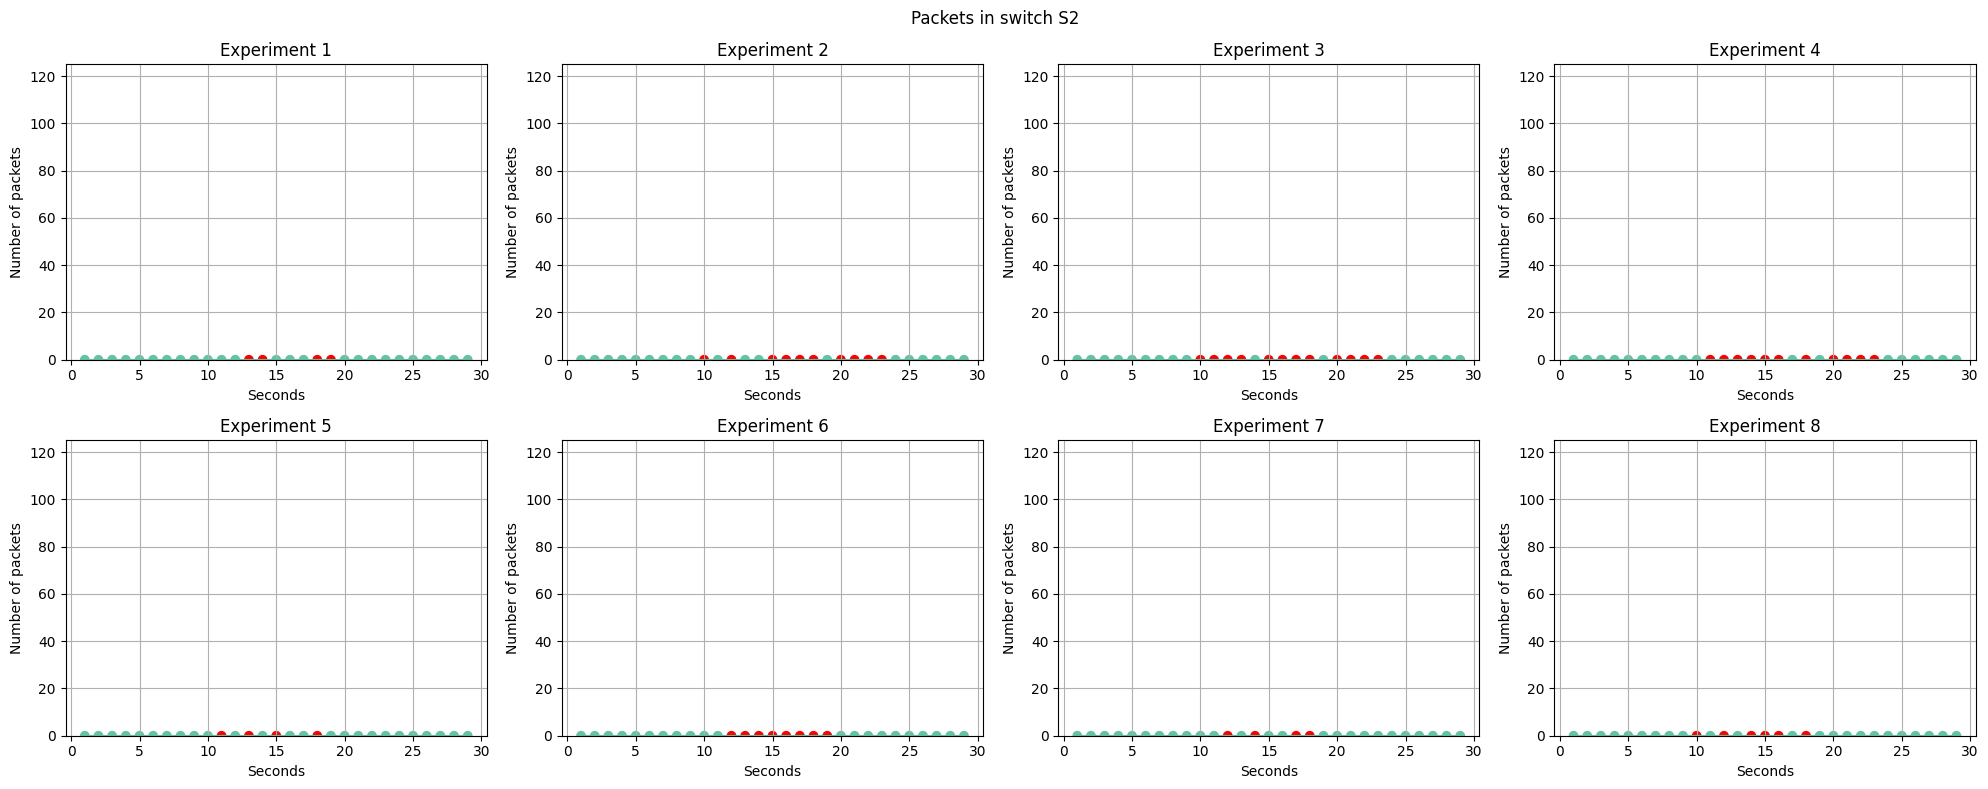

In [6]:
plt.figure(figsize=(20, 8))
swidSwitch = "QDepth_SWID_2"

plt.subplot(2,4,1)
result_df = experiments["exp1"][1:]
colors = ["red" if val == -1 else cmap(0) for val in result_df['sorted_array']]
packet_numbers = result_df.index
plt.plot(packet_numbers, result_df[f'{swidSwitch}'], label=f'{swidSwitch}',color=cmap(0))
plt.scatter(packet_numbers, result_df[f'{swidSwitch}'], c=colors, label=f'{swidSwitch}', marker='o')

plt.xlabel('Seconds')
plt.ylabel('Number of packets')
plt.title('Experiment 1')
plt.ylim([0, int(max_buffer2)+25])
plt.grid(True)

plt.subplot(2,4,2)
result_df = experiments["exp2"][1:]
colors = ["red" if val == -1 else cmap(0) for val in result_df['sorted_array']]
packet_numbers = result_df.index
plt.scatter(packet_numbers, result_df[f'{swidSwitch}'], c=colors, label=f'{swidSwitch}', marker='o')
plt.plot(packet_numbers, result_df[f'{swidSwitch}'], label=f'{swidSwitch}',color=cmap(0))
plt.xlabel('Seconds')
plt.ylabel('Number of packets')
plt.title('Experiment 2')
plt.ylim([0, int(max_buffer2)+25])
plt.grid(True)

plt.subplot(2,4,3)
result_df = experiments["exp3"][1:]
colors = ["red" if val == -1 else cmap(0) for val in result_df['sorted_array']]
packet_numbers = result_df.index
plt.scatter(packet_numbers, result_df[f'{swidSwitch}'], c=colors, label=f'{swidSwitch}', marker='o')
plt.plot(packet_numbers, result_df[f'{swidSwitch}'], label=f'{swidSwitch}',color=cmap(0))
plt.xlabel('Seconds')
plt.ylabel('Number of packets')
plt.title('Experiment 3')
plt.ylim([0, int(max_buffer2)+25])
plt.grid(True)

plt.subplot(2,4,4)
result_df = experiments["exp4"][1:]
colors = ["red" if val == -1 else cmap(0) for val in result_df['sorted_array']]
packet_numbers = result_df.index
plt.scatter(packet_numbers, result_df[f'{swidSwitch}'], c=colors, label=f'{swidSwitch}', marker='o')
plt.plot(packet_numbers, result_df[f'{swidSwitch}'], label=f'{swidSwitch}',color=cmap(0))
plt.xlabel('Seconds')
plt.ylabel('Number of packets')
plt.title('Experiment 4')
plt.ylim([0, int(max_buffer2)+25])
plt.grid(True)

plt.subplot(2,4,5)
result_df = experiments["exp5"][1:]
colors = ["red" if val == -1 else cmap(0) for val in result_df['sorted_array']]
packet_numbers = result_df.index
plt.scatter(packet_numbers, result_df[f'{swidSwitch}'], c=colors, label=f'{swidSwitch}', marker='o')
plt.plot(packet_numbers, result_df[f'{swidSwitch}'], label=f'{swidSwitch}',color=cmap(0))
plt.xlabel('Seconds')
plt.ylabel('Number of packets')
plt.title('Experiment 5')
plt.ylim([0, int(max_buffer2)+25])
plt.grid(True)

plt.subplot(2,4,6)
result_df = experiments["exp6"][1:]
colors = ["red" if val == -1 else cmap(0) for val in result_df['sorted_array']]
packet_numbers = result_df.index
plt.scatter(packet_numbers, result_df[f'{swidSwitch}'], c=colors, label=f'{swidSwitch}', marker='o')
plt.plot(packet_numbers, result_df[f'{swidSwitch}'], label=f'{swidSwitch}',color=cmap(0))
plt.xlabel('Seconds')
plt.ylabel('Number of packets')
plt.title('Experiment 6')
plt.ylim([0, int(max_buffer2)+25])
plt.grid(True)

plt.subplot(2,4,7)
result_df = experiments["exp7"][1:]
colors = ["red" if val == -1 else cmap(0) for val in result_df['sorted_array']]
packet_numbers = result_df.index
plt.scatter(packet_numbers, result_df[f'{swidSwitch}'], c=colors, label=f'{swidSwitch}', marker='o')
plt.plot(packet_numbers, result_df[f'{swidSwitch}'], label=f'{swidSwitch}',color=cmap(0))
plt.xlabel('Seconds')
plt.ylabel('Number of packets')
plt.title('Experiment 7')
plt.ylim([0, int(max_buffer2)+25])
plt.grid(True)

plt.subplot(2,4,8)
result_df = experiments["exp8"][1:]
colors = ["red" if val == -1 else cmap(0) for val in result_df['sorted_array']]
packet_numbers = result_df.index
plt.scatter(packet_numbers, result_df[f'{swidSwitch}'], c=colors, label=f'{swidSwitch}', marker='o')
plt.plot(packet_numbers, result_df[f'{swidSwitch}'], label=f'{swidSwitch}',color=cmap(0))
plt.xlabel('Seconds')
plt.ylabel('Number of packets')
plt.title('Experiment 8')
plt.ylim([0, int(max_buffer2)+25])
plt.grid(True)


plt.suptitle('Packets in switch S2')
plt.tight_layout()
plt.savefig('./graphs/figures/QDepth_exp0_S2.png')
plt.show()

### Lost Packets per thread

In [7]:
experiments = {"exp1" : None, "exp2" : None, "exp3" : None, "exp4" : None, "exp5" : None, "exp6" : None, "exp7" : None, "exp8" : None}
for experiment in experiments:
    with open(f'./graphs/data/{experiment}.json') as f:
        data = json.load(f)
    streams = data['end']['streams']
    lost_packets = []
    packets = []
    for i, streams in enumerate(streams):
        lost_packets.append(streams['udp']['lost_packets'])
        packets.append(streams['udp']['packets'])
    data = {
        'lost_packets': lost_packets,
        'packets': packets
    }
    experiments[experiment] =  pd.DataFrame(data)

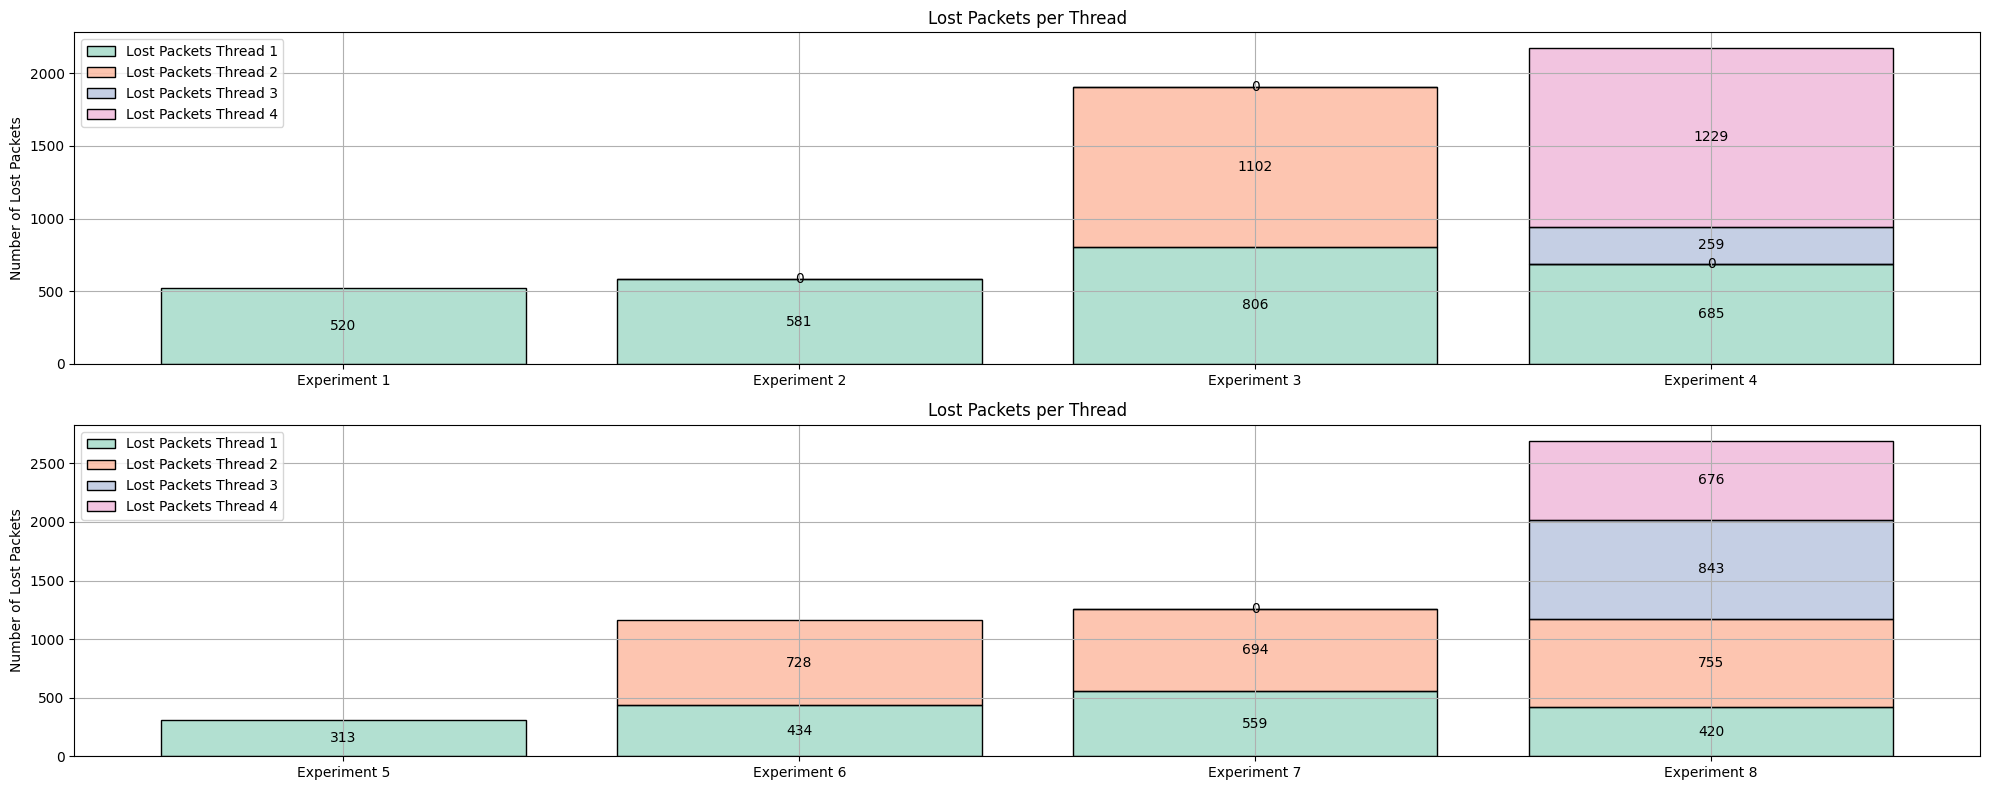

In [8]:
def add_alpha(color, alpha=0.7):
    try:
        c = mcolors.cnames[color]
    except:
        c = color
    c = mcolors.to_rgba(c)
    return (c[0], c[1], c[2], alpha)

cmap = plt.get_cmap('Set2')
plt.figure(figsize=(20, 8))

plt.subplot(2, 1, 1)
legend_labels = set()
for i in range(1, 5):
    df = experiments[f"exp{i}"]
    lost_packets = df['lost_packets']
    total_packets = df['packets'].sum()
    labels = [f'Lost Packets Thread {j+1}' for j in range(len(lost_packets))]
    colors = [add_alpha(cmap(j), 0.5) for j in range(len(lost_packets))]
    bottom = 0
    for lost, label, color in zip(lost_packets, labels, colors):
        percentage = (lost / total_packets) * 100
        bar = plt.bar(i, lost, bottom=bottom, color=color, edgecolor='black')
        plt.text(i, bottom + lost / 2, f'{lost}', ha='center', va='center', color='black')
        if label not in legend_labels:
            legend_labels.add(label)
            bar.set_label(label)
        bottom += lost

plt.xticks(range(1, 5), [f'Experiment {i}' for i in range(1, 5)])
plt.ylabel('Number of Lost Packets')
plt.title('Lost Packets per Thread')
plt.legend()
plt.grid(True)

legend_labels = set()
plt.subplot(2, 1, 2)
for i in range(5, 9):
    df = experiments[f"exp{i}"]
    lost_packets = df['lost_packets']
    total_packets = df['packets'].sum()
    labels = [f'Lost Packets Thread {j+1}' for j in range(len(lost_packets))]
    colors = [add_alpha(cmap(j), 0.5) for j in range(len(lost_packets))]
    bottom = 0
    for lost, label, color in zip(lost_packets, labels, colors):
        percentage = (lost / total_packets) * 100
        bar = plt.bar(i, lost, bottom=bottom, color=color, edgecolor='black')
        plt.text(i, bottom + lost / 2, f'{lost}', ha='center', va='center', color='black')
        if label not in legend_labels:
            legend_labels.add(label)
            bar.set_label(label)
        bottom += lost

plt.xticks(range(5,9), [f'Experiment {i}' for i in range(5, 9)])
plt.ylabel('Number of Lost Packets')
plt.title('Lost Packets per Thread')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('./graphs/figures/LP_exp0.png')
plt.show()

### Number of packets in each interface

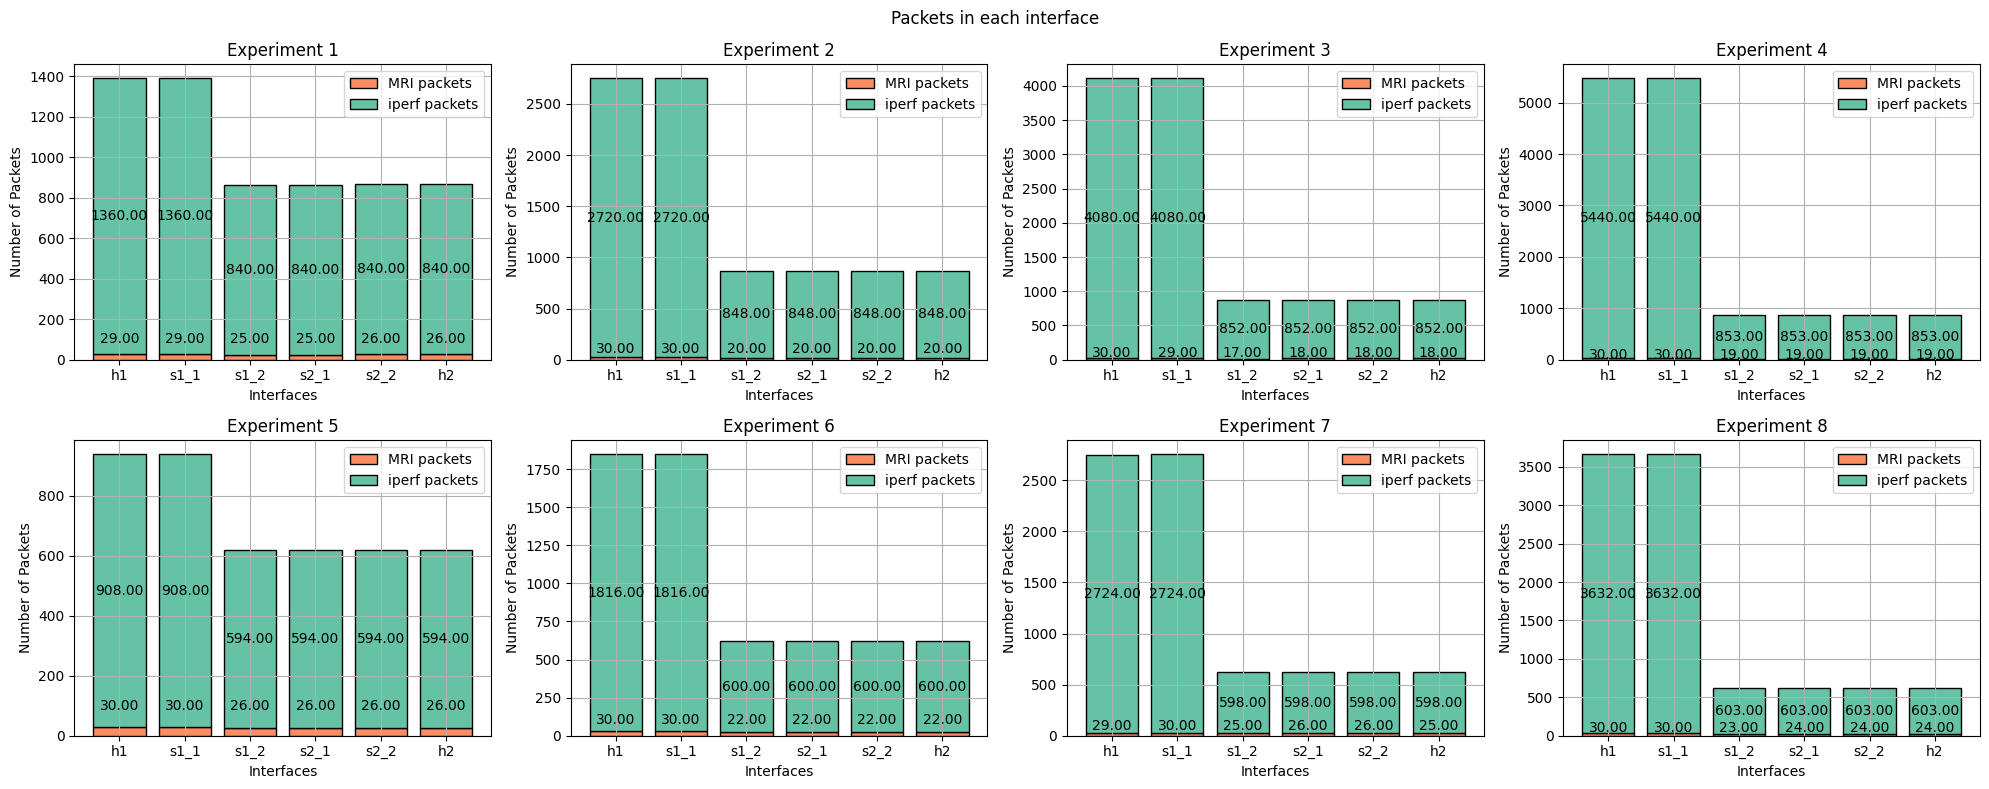

In [9]:
import pandas as pd
import matplotlib.pyplot as plt


plt.figure(figsize=(20, 8))
for experiment in range(1, 9):
    file_path = f'./graphs/data/exp{experiment}_nH.csv'
    dfh = pd.read_csv(file_path)
    
    file_path = f'./graphs/data/exp{experiment}_nS1.csv'
    dfs1 = pd.read_csv(file_path)
    
    file_path = f'./graphs/data/exp{experiment}_nS2.csv'
    dfs2 = pd.read_csv(file_path)
    
    h1_MRI = dfh.iloc[0]['h1_MRI']
    h1_iperf = dfh.iloc[0]['h1_iperf']
    h2_MRI = dfh.iloc[0]['h2_MRI']
    h2_iperf = dfh.iloc[0]['h2_iperf']
    
    s1_1_MRI = dfs1.iloc[0]['s11_MRI']
    s1_1_iperf = dfs1.iloc[0]['s11_iperf']
    s1_2_MRI = dfs1.iloc[0]['s12_MRI']
    s1_2_iperf = dfs1.iloc[0]['s12_iperf']
    
    s2_1_MRI = dfs2.iloc[0]['s21_MRI']
    s2_1_iperf = dfs2.iloc[0]['s21_iperf']
    s2_2_MRI = dfs2.iloc[0]['s22_MRI']
    s2_2_iperf = dfs2.iloc[0]['s22_iperf']

    plt.subplot(2, 4, experiment)
    labels = ["MRI packets", "iperf packets"]
    legend_labels = set()
    cmap = plt.get_cmap('Set2')
    colors = [ cmap(1), cmap(0)]

    bottom = 0
    for packets, label, color in zip([h1_MRI, h1_iperf], labels, colors):
        bar = plt.bar(1, packets, bottom=bottom, color=color, edgecolor='black')
        if label == "MRI packets":
            plt.text(1, bottom + 100, f'{packets:.2f}', ha='center', va='center', color='black')
        if label == "iperf packets":
            plt.text(1, bottom + packets / 2, f'{packets:.2f}', ha='center', va='center', color='black')
        if label not in legend_labels:
            legend_labels.add(label)
            bar.set_label(label)
        bottom += packets
    
    bottom = 0
    for packets, label, color in zip([s1_1_MRI, s1_1_iperf], labels, colors):
        bar = plt.bar(2, packets, bottom=bottom, color=color, edgecolor='black')
        if label == "MRI packets":
            plt.text(2, bottom + 100, f'{packets:.2f}', ha='center', va='center', color='black')
        if label == "iperf packets":
            plt.text(2, bottom + packets / 2, f'{packets:.2f}', ha='center', va='center', color='black')
        if label not in legend_labels:
            legend_labels.add(label)
            bar.set_label(label)
        bottom += packets
    
    bottom = 0
    for packets, label, color in zip([s1_2_MRI, s1_2_iperf], labels, colors):
        bar = plt.bar(3, packets, bottom=bottom, color=color, edgecolor='black')
        if label == "MRI packets":
            plt.text(3, bottom + 100, f'{packets:.2f}', ha='center', va='center', color='black')
        if label == "iperf packets":
            plt.text(3, bottom + packets / 2, f'{packets:.2f}', ha='center', va='center', color='black')
        if label not in legend_labels:
            legend_labels.add(label)
            bar.set_label(label)
        bottom += packets
    
    bottom = 0
    for packets, label, color in zip([s2_1_MRI, s2_1_iperf], labels, colors):
        bar = plt.bar(4, packets, bottom=bottom, color=color, edgecolor='black')
        if label == "MRI packets":
            plt.text(4, bottom + 100, f'{packets:.2f}', ha='center', va='center', color='black')
        if label == "iperf packets":
            plt.text(4, bottom + packets / 2, f'{packets:.2f}', ha='center', va='center', color='black')
        if label not in legend_labels:
            legend_labels.add(label)
            bar.set_label(label)
        bottom += packets
    
    bottom = 0
    for packets, label, color in zip([s2_2_MRI, s2_2_iperf], labels, colors):
        bar = plt.bar(5, packets, bottom=bottom, color=color, edgecolor='black')
        if label == "MRI packets":
            plt.text(5, bottom + 100, f'{packets:.2f}', ha='center', va='center', color='black')
        if label == "iperf packets":
            plt.text(5, bottom + packets / 2, f'{packets:.2f}', ha='center', va='center', color='black')
        if label not in legend_labels:
            legend_labels.add(label)
            bar.set_label(label)
        bottom += packets
    
    bottom = 0
    for packets, label, color in zip([h2_MRI, h2_iperf], labels, colors):
        bar = plt.bar(6, packets, bottom=bottom, color=color, edgecolor='black')
        if label == "MRI packets":
            plt.text(6, bottom + 100, f'{packets:.2f}', ha='center', va='center', color='black')
        if label == "iperf packets":
            plt.text(6, bottom + packets / 2, f'{packets:.2f}', ha='center', va='center', color='black')
        if label not in legend_labels:
            legend_labels.add(label)
            bar.set_label(label)
        bottom += packets
    
    plt.xticks([1, 2, 3, 4, 5, 6], ['h1', 's1_1', 's1_2', 's2_1', 's2_2', 'h2'])
    plt.ylabel('Number of Packets')
    plt.xlabel('Interfaces')
    plt.title(f'Experiment {experiment}')
    plt.legend()
    plt.grid(True)


plt.suptitle('Packets in each interface')
plt.tight_layout()
plt.savefig('./graphs/figures/nP_exp0.png')
plt.show()

## Experiments 11-18 graphs

### Bandwidth

In [10]:
experiments = {"exp11" : None, "exp12" : None, "exp13" : None, "exp14" : None, "exp15" : None, "exp16" : None, "exp17" : None, "exp18" : None}
for experiment in experiments:
    with open(f'./graphs/data/{experiment}.json') as f:
        data = json.load(f)
    intervals = data['intervals']
    times = []

    for i in range(30):
        times.append(i+1)

    iperf_bandwidth = []

    for i in range(5):
        iperf_bandwidth.append(0)

    for interval in enumerate(intervals):
        iperf_bandwidth.append(interval[1]['sum']['bits_per_second'])

    n = 10 if experiment == 'exp11' or experiment == 'exp12' or experiment == 'exp13' or experiment == 'exp14' else 15
    for i in range(n):
        iperf_bandwidth.append(0)
    data = {
        'times': times,
        'iperf_bandwidth': iperf_bandwidth,
    }
    experiments[experiment] =  pd.DataFrame(data)
    
MRI_bandwidth = []
for i in range(30):
    MRI_bandwidth.append(544)

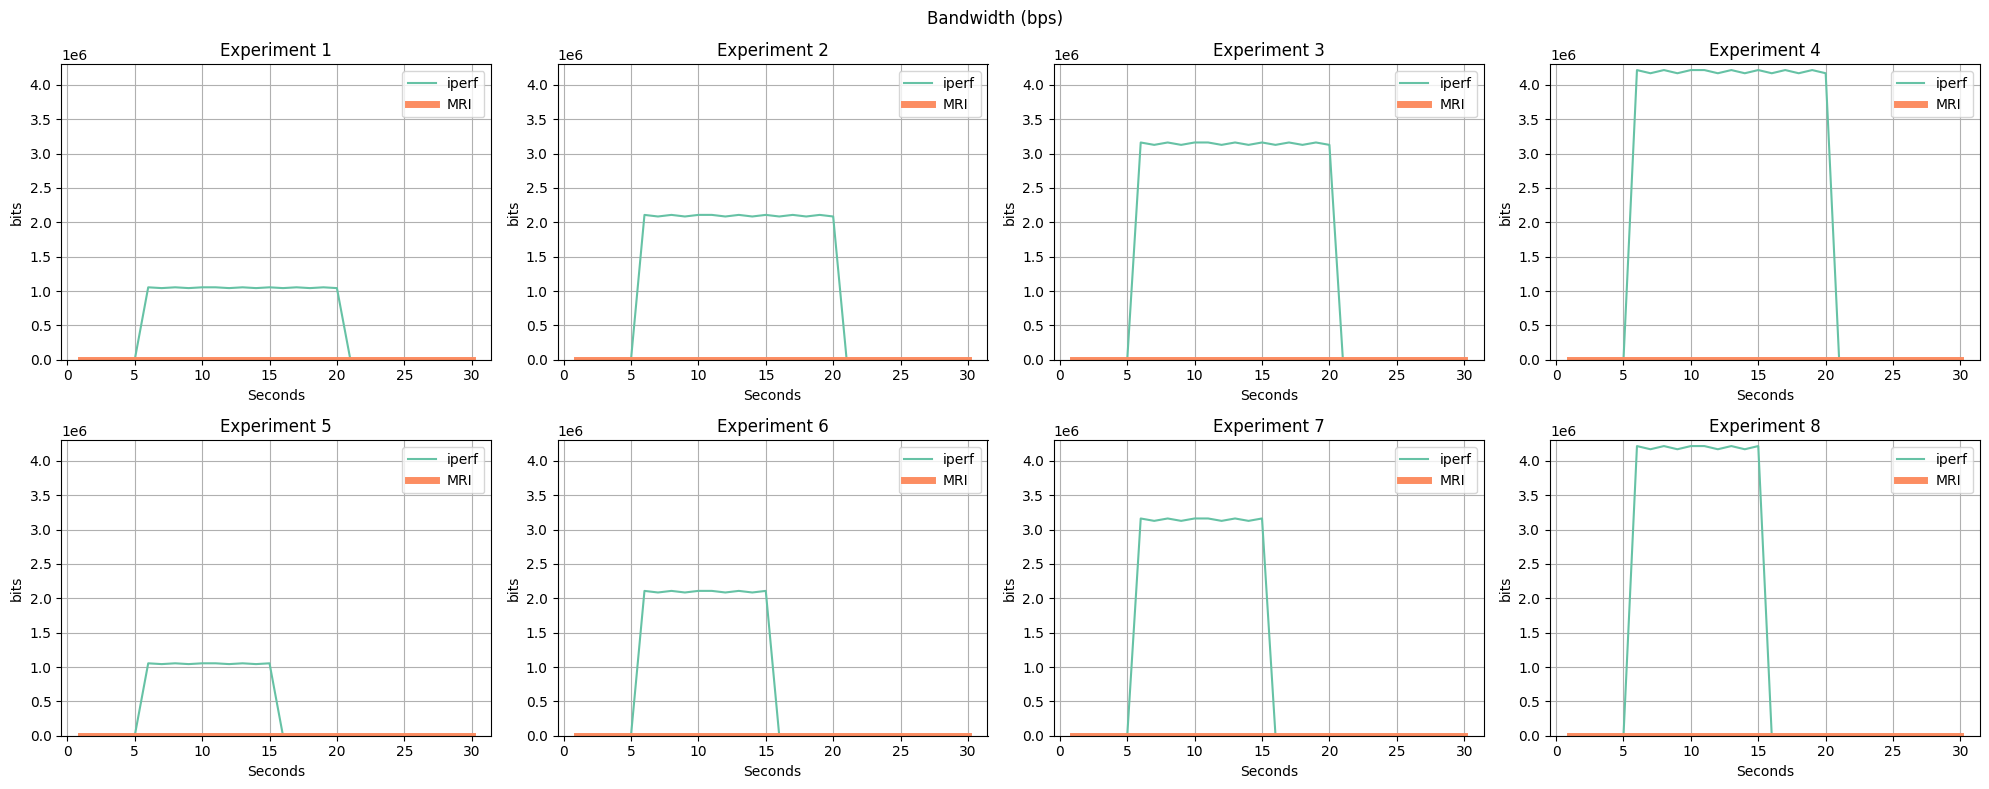

In [11]:
plt.figure(figsize=(20, 8))

for n in range(1,9):
    plt.subplot(2,4,n)
    result_df = experiments[f"exp1{n}"]
    plt.plot(result_df["times"], result_df["iperf_bandwidth"], linestyle='-', color=cmap(0),label="iperf")
    plt.plot(result_df["times"], MRI_bandwidth, linestyle='-', color=cmap(1), linewidth=5,label="MRI") 
    plt.title(f'Experiment {n}')
    plt.xlabel('Seconds')
    plt.ylabel('bits')
    plt.ylim([0, 4.3e6])
    plt.legend()
    plt.grid(True)

plt.suptitle('Bandwidth (bps)')
plt.tight_layout()
plt.savefig('./graphs/figures/BW_exp10.png')
plt.show()

### Number of packets in the buffer of each switch

In [12]:
experiments = {"exp11" : None, "exp12" : None, "exp13" : None, "exp14" : None, "exp15" : None, "exp16" : None, "exp17" : None, "exp18" : None}
max_buffer1 = 50
max_buffer2 = 50

for experiment in experiments:
    df = pd.read_csv(f'./graphs/data/{experiment}.csv')
    hex_list = df['Values'].tolist()
    packet_numbers = [int(packet[-2:], 16) for packet in hex_list]
    max_value = max(packet_numbers)
    sorted_array = [-1] * (max_value + 1)
    for number in packet_numbers:
        sorted_array[number] = number
    qdepth_values_swid_1 = [max_buffer1 if x == -1 else None for x in sorted_array]
    #qdepth_values_swid_2 = [None for x in sorted_array]
    qdepth_values_swid_2 = [0 if x == -1 else None for x in sorted_array]
    #qdepth_values_swid_2 = [max_buffer2 if x == -1 else None for x in sorted_array]
    for index, pkt in enumerate(hex_list):
        if sorted_array[int(pkt[-2:], 16)] != -1:
            packet_bytes = bytes.fromhex(pkt)
            packet_reconstructed = Ether(packet_bytes)
            mri_layer = packet_reconstructed.getlayer(IPOption_MRI)
            qdepth_value_swid_1 = None
            qdepth_value_swid_2 = None
            if mri_layer:
                for sw_trace in mri_layer.swtraces:
                    if sw_trace.swid == 1:
                        qdepth_value_swid_1 = sw_trace.qdepth
                    elif sw_trace.swid == 2:
                        qdepth_value_swid_2 = sw_trace.qdepth
    
            if qdepth_value_swid_1 is not None:
                qdepth_values_swid_1[int(pkt[-2:], 16)] = qdepth_value_swid_1
            #if qdepth_value_swid_2 is not None:
                qdepth_values_swid_2[int(pkt[-2:], 16)] = qdepth_value_swid_2
    data = {
        'QDepth_SWID_1': qdepth_values_swid_1,
        'QDepth_SWID_2': qdepth_values_swid_2,
        'sorted_array': sorted_array,
    }
    
    experiments[experiment] =  pd.DataFrame(data)

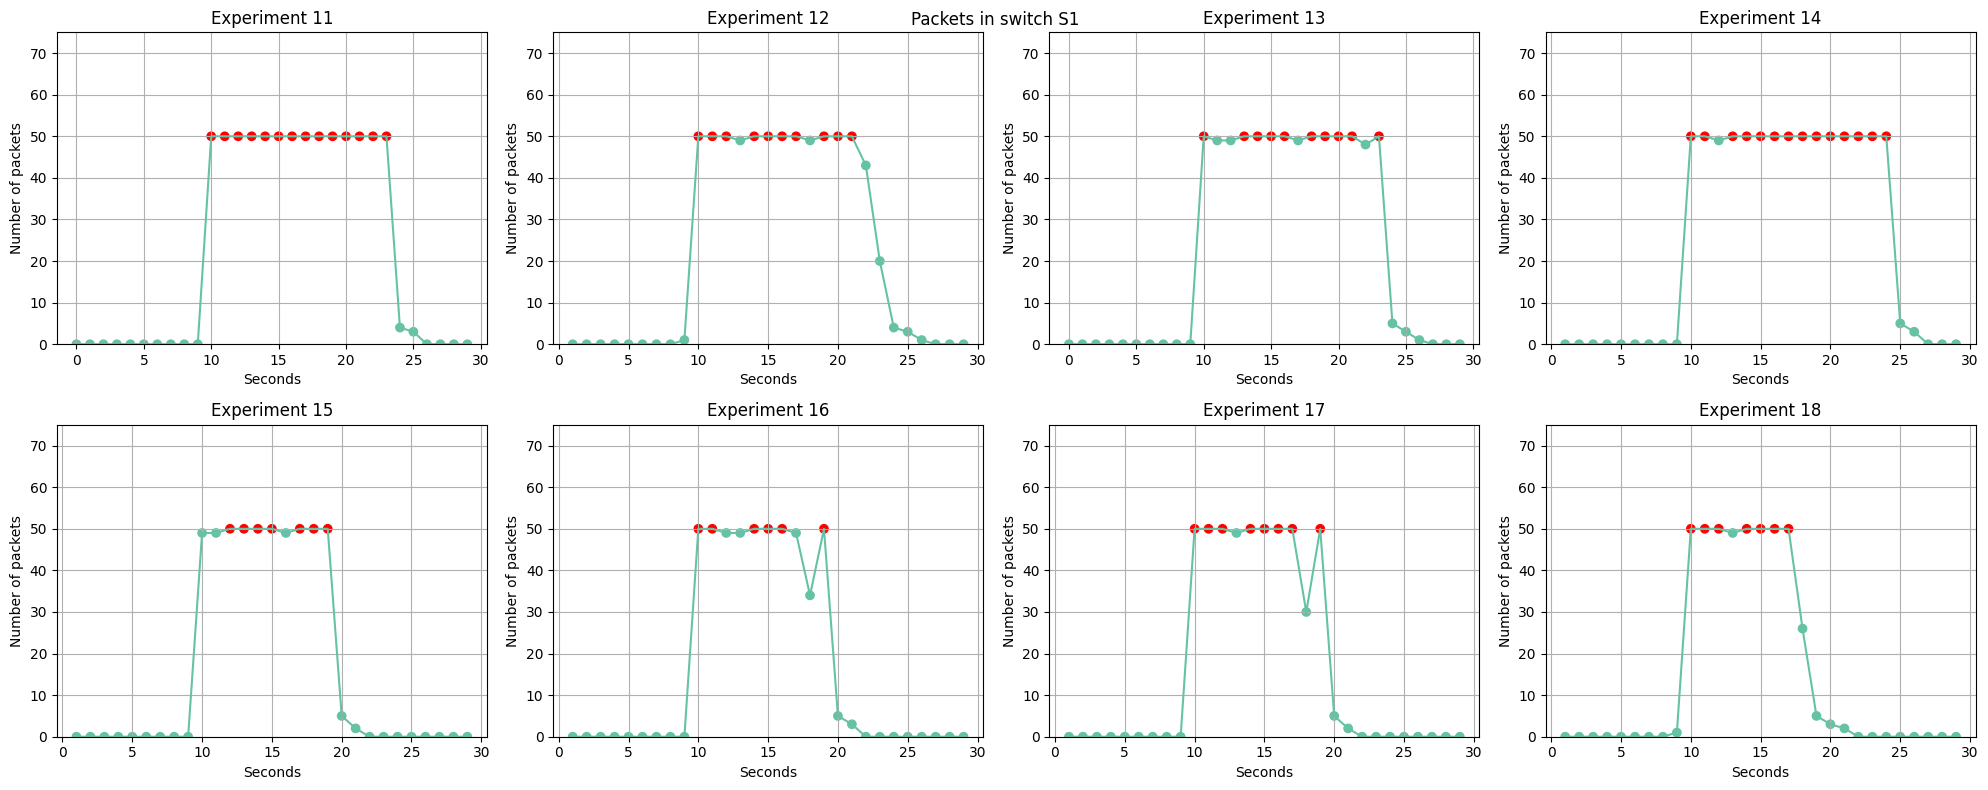

In [13]:
plt.figure(figsize=(20, 8))
swidSwitch = "QDepth_SWID_1"

plt.subplot(2,4,1)
result_df = experiments["exp11"]
colors = ["red" if val == -1 else cmap(0) for val in result_df['sorted_array']]
packet_numbers = result_df.index
plt.plot(packet_numbers, result_df[f'{swidSwitch}'], label=f'{swidSwitch}',color=cmap(0))
plt.scatter(packet_numbers, result_df[f'{swidSwitch}'], c=colors, label=f'{swidSwitch}', marker='o')
plt.xlabel('Seconds')
plt.ylabel('Number of packets')
plt.title('Experiment 11')
plt.ylim([0, int(max_buffer1)+25])
plt.grid(True)

plt.subplot(2,4,2)
result_df = experiments["exp12"][1:]
colors = ["red" if val == -1 else cmap(0) for val in result_df['sorted_array']]
packet_numbers = result_df.index
plt.scatter(packet_numbers, result_df[f'{swidSwitch}'], c=colors, label=f'{swidSwitch}', marker='o')
plt.plot(packet_numbers, result_df[f'{swidSwitch}'], label=f'{swidSwitch}',color=cmap(0))
plt.xlabel('Seconds')
plt.ylabel('Number of packets')
plt.title('Experiment 12')
plt.ylim([0, int(max_buffer1)+25])
plt.grid(True)

plt.subplot(2,4,3)
result_df = experiments["exp13"]
colors = ["red" if val == -1 else cmap(0) for val in result_df['sorted_array']]
packet_numbers = result_df.index
plt.scatter(packet_numbers, result_df[f'{swidSwitch}'], c=colors, label=f'{swidSwitch}', marker='o')
plt.plot(packet_numbers, result_df[f'{swidSwitch}'], label=f'{swidSwitch}',color=cmap(0))
plt.xlabel('Seconds')
plt.ylabel('Number of packets')
plt.title('Experiment 13')
plt.ylim([0, int(max_buffer1)+25])
plt.grid(True)

plt.subplot(2,4,4)
result_df = experiments["exp14"][1:]
colors = ["red" if val == -1 else cmap(0) for val in result_df['sorted_array']]
packet_numbers = result_df.index
plt.scatter(packet_numbers, result_df[f'{swidSwitch}'], c=colors, label=f'{swidSwitch}', marker='o')
plt.plot(packet_numbers, result_df[f'{swidSwitch}'], label=f'{swidSwitch}',color=cmap(0))
plt.xlabel('Seconds')
plt.ylabel('Number of packets')
plt.title('Experiment 14')
plt.ylim([0, int(max_buffer1)+25])
plt.grid(True)

plt.subplot(2,4,5)
result_df = experiments["exp15"][1:]
colors = ["red" if val == -1 else cmap(0) for val in result_df['sorted_array']]
packet_numbers = result_df.index
plt.scatter(packet_numbers, result_df[f'{swidSwitch}'], c=colors, label=f'{swidSwitch}', marker='o')
plt.plot(packet_numbers, result_df[f'{swidSwitch}'], label=f'{swidSwitch}',color=cmap(0))
plt.xlabel('Seconds')
plt.ylabel('Number of packets')
plt.title('Experiment 15')
plt.ylim([0, int(max_buffer1)+25])
plt.grid(True)

plt.subplot(2,4,6)
result_df = experiments["exp16"][1:]
colors = ["red" if val == -1 else cmap(0) for val in result_df['sorted_array']]
packet_numbers = result_df.index
plt.scatter(packet_numbers, result_df[f'{swidSwitch}'], c=colors, label=f'{swidSwitch}', marker='o')
plt.plot(packet_numbers, result_df[f'{swidSwitch}'], label=f'{swidSwitch}',color=cmap(0))
plt.xlabel('Seconds')
plt.ylabel('Number of packets')
plt.title('Experiment 16')
plt.ylim([0, int(max_buffer1)+25])
plt.grid(True)

plt.subplot(2,4,7)
result_df = experiments["exp17"][1:]
colors = ["red" if val == -1 else cmap(0) for val in result_df['sorted_array']]
packet_numbers = result_df.index
plt.scatter(packet_numbers, result_df[f'{swidSwitch}'], c=colors, label=f'{swidSwitch}', marker='o')
plt.plot(packet_numbers, result_df[f'{swidSwitch}'], label=f'{swidSwitch}',color=cmap(0))
plt.xlabel('Seconds')
plt.ylabel('Number of packets')
plt.title('Experiment 17')
plt.ylim([0, int(max_buffer1)+25])
plt.grid(True)

plt.subplot(2,4,8)
result_df = experiments["exp18"][1:]
colors = ["red" if val == -1 else cmap(0) for val in result_df['sorted_array']]
packet_numbers = result_df.index
plt.scatter(packet_numbers, result_df[f'{swidSwitch}'], c=colors, label=f'{swidSwitch}', marker='o')
plt.plot(packet_numbers, result_df[f'{swidSwitch}'], label=f'{swidSwitch}',color=cmap(0))
plt.xlabel('Seconds')
plt.ylabel('Number of packets')
plt.title('Experiment 18')
plt.ylim([0, int(max_buffer1)+25])
plt.grid(True)

plt.tight_layout()

plt.suptitle('Packets in switch S1')
plt.savefig('./graphs/figures/QDepth_exp10_S1.png')
plt.show()

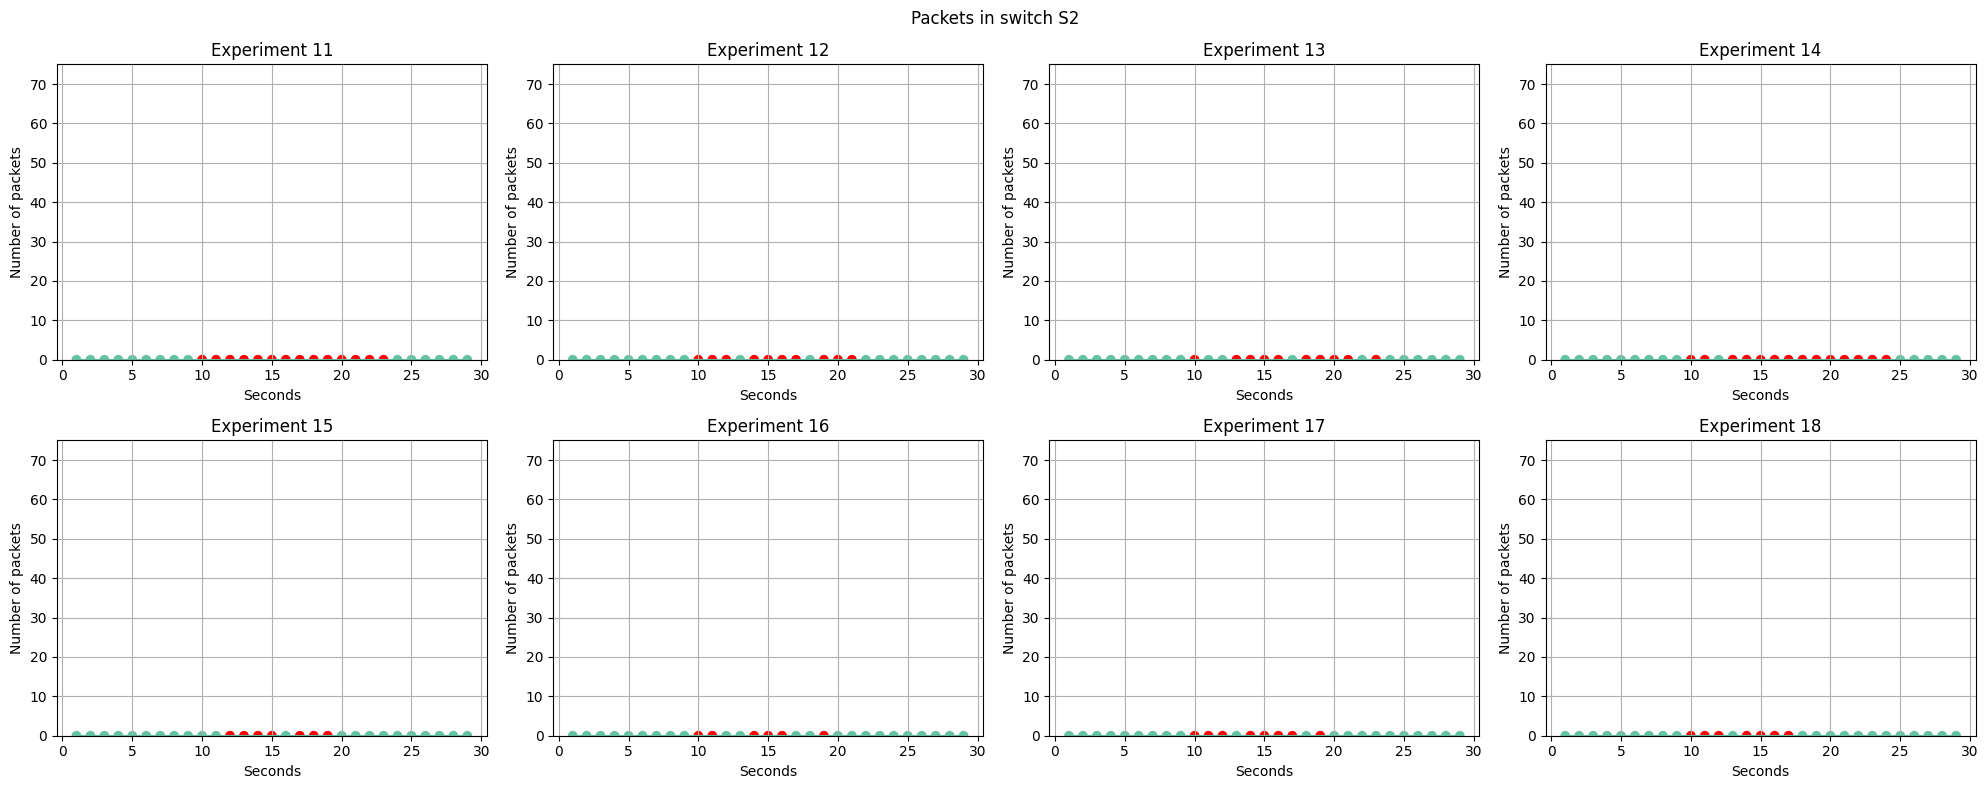

In [14]:
plt.figure(figsize=(20, 8))
swidSwitch = "QDepth_SWID_2"

plt.subplot(2,4,1)
result_df = experiments["exp11"][1:]
colors = ["red" if val == -1 else cmap(0) for val in result_df['sorted_array']]
packet_numbers = result_df.index
plt.plot(packet_numbers, result_df[f'{swidSwitch}'], label=f'{swidSwitch}',color=cmap(0))
plt.scatter(packet_numbers, result_df[f'{swidSwitch}'], c=colors, label=f'{swidSwitch}', marker='o')

plt.xlabel('Seconds')
plt.ylabel('Number of packets')
plt.title('Experiment 11')
plt.ylim([0, int(max_buffer2)+25])
plt.grid(True)

plt.subplot(2,4,2)
result_df = experiments["exp12"][1:]
colors = ["red" if val == -1 else cmap(0) for val in result_df['sorted_array']]
packet_numbers = result_df.index
plt.scatter(packet_numbers, result_df[f'{swidSwitch}'], c=colors, label=f'{swidSwitch}', marker='o')
plt.plot(packet_numbers, result_df[f'{swidSwitch}'], label=f'{swidSwitch}',color=cmap(0))
plt.xlabel('Seconds')
plt.ylabel('Number of packets')
plt.title('Experiment 12')
plt.ylim([0, int(max_buffer2)+25])
plt.grid(True)

plt.subplot(2,4,3)
result_df = experiments["exp13"][1:]
colors = ["red" if val == -1 else cmap(0) for val in result_df['sorted_array']]
packet_numbers = result_df.index
plt.scatter(packet_numbers, result_df[f'{swidSwitch}'], c=colors, label=f'{swidSwitch}', marker='o')
plt.plot(packet_numbers, result_df[f'{swidSwitch}'], label=f'{swidSwitch}',color=cmap(0))
plt.xlabel('Seconds')
plt.ylabel('Number of packets')
plt.title('Experiment 13')
plt.ylim([0, int(max_buffer2)+25])
plt.grid(True)

plt.subplot(2,4,4)
result_df = experiments["exp14"][1:]
colors = ["red" if val == -1 else cmap(0) for val in result_df['sorted_array']]
packet_numbers = result_df.index
plt.scatter(packet_numbers, result_df[f'{swidSwitch}'], c=colors, label=f'{swidSwitch}', marker='o')
plt.plot(packet_numbers, result_df[f'{swidSwitch}'], label=f'{swidSwitch}',color=cmap(0))
plt.xlabel('Seconds')
plt.ylabel('Number of packets')
plt.title('Experiment 14')
plt.ylim([0, int(max_buffer2)+25])
plt.grid(True)

plt.subplot(2,4,5)
result_df = experiments["exp15"][1:]
colors = ["red" if val == -1 else cmap(0) for val in result_df['sorted_array']]
packet_numbers = result_df.index
plt.scatter(packet_numbers, result_df[f'{swidSwitch}'], c=colors, label=f'{swidSwitch}', marker='o')
plt.plot(packet_numbers, result_df[f'{swidSwitch}'], label=f'{swidSwitch}',color=cmap(0))
plt.xlabel('Seconds')
plt.ylabel('Number of packets')
plt.title('Experiment 15')
plt.ylim([0, int(max_buffer2)+25])
plt.grid(True)

plt.subplot(2,4,6)
result_df = experiments["exp16"][1:]
colors = ["red" if val == -1 else cmap(0) for val in result_df['sorted_array']]
packet_numbers = result_df.index
plt.scatter(packet_numbers, result_df[f'{swidSwitch}'], c=colors, label=f'{swidSwitch}', marker='o')
plt.plot(packet_numbers, result_df[f'{swidSwitch}'], label=f'{swidSwitch}',color=cmap(0))
plt.xlabel('Seconds')
plt.ylabel('Number of packets')
plt.title('Experiment 16')
plt.ylim([0, int(max_buffer2)+25])
plt.grid(True)

plt.subplot(2,4,7)
result_df = experiments["exp17"][1:]
colors = ["red" if val == -1 else cmap(0) for val in result_df['sorted_array']]
packet_numbers = result_df.index
plt.scatter(packet_numbers, result_df[f'{swidSwitch}'], c=colors, label=f'{swidSwitch}', marker='o')
plt.plot(packet_numbers, result_df[f'{swidSwitch}'], label=f'{swidSwitch}',color=cmap(0))
plt.xlabel('Seconds')
plt.ylabel('Number of packets')
plt.title('Experiment 17')
plt.ylim([0, int(max_buffer2)+25])
plt.grid(True)

plt.subplot(2,4,8)
result_df = experiments["exp18"][1:]
colors = ["red" if val == -1 else cmap(0) for val in result_df['sorted_array']]
packet_numbers = result_df.index
plt.scatter(packet_numbers, result_df[f'{swidSwitch}'], c=colors, label=f'{swidSwitch}', marker='o')
plt.plot(packet_numbers, result_df[f'{swidSwitch}'], label=f'{swidSwitch}',color=cmap(0))
plt.xlabel('Seconds')
plt.ylabel('Number of packets')
plt.title('Experiment 18')
plt.ylim([0, int(max_buffer2)+25])
plt.grid(True)


plt.suptitle('Packets in switch S2')
plt.tight_layout()
plt.savefig('./graphs/figures/QDepth_exp10_S2.png')
plt.show()

### Lost Packets per thread

In [15]:
experiments = {"exp11" : None, "exp12" : None, "exp13" : None, "exp14" : None, "exp15" : None, "exp16" : None, "exp17" : None, "exp18" : None}
for experiment in experiments:
    with open(f'./graphs/data/{experiment}.json') as f:
        data = json.load(f)
    streams = data['end']['streams']
    lost_packets = []
    packets = []
    for i, streams in enumerate(streams):
        lost_packets.append(streams['udp']['lost_packets'])
        packets.append(streams['udp']['packets'])
    data = {
        'lost_packets': lost_packets,
        'packets': packets
    }
    experiments[experiment] =  pd.DataFrame(data)

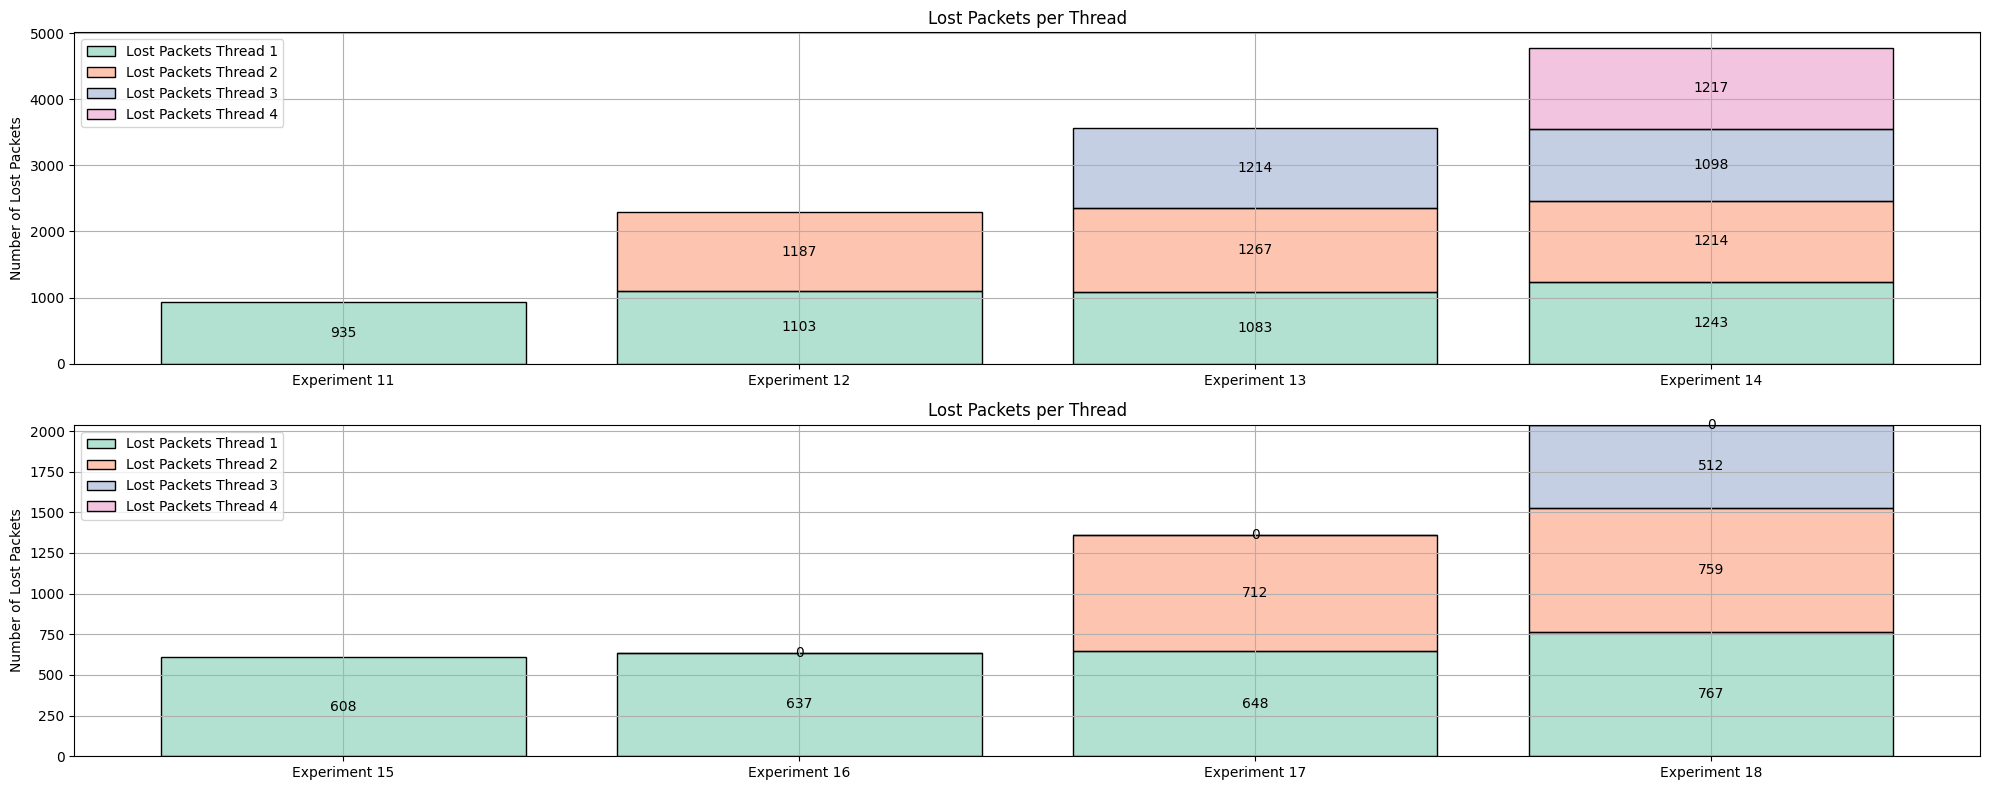

In [16]:
def add_alpha(color, alpha=0.7):
    try:
        c = mcolors.cnames[color]
    except:
        c = color
    c = mcolors.to_rgba(c)
    return (c[0], c[1], c[2], alpha)

cmap = plt.get_cmap('Set2')
plt.figure(figsize=(20, 8))

plt.subplot(2, 1, 1)
legend_labels = set()
for i in range(1, 5):
    df = experiments[f"exp1{i}"]
    lost_packets = df['lost_packets']
    total_packets = df['packets'].sum()
    labels = [f'Lost Packets Thread {j+1}' for j in range(len(lost_packets))]
    colors = [add_alpha(cmap(j), 0.5) for j in range(len(lost_packets))]
    bottom = 0
    for lost, label, color in zip(lost_packets, labels, colors):
        percentage = (lost / total_packets) * 100
        bar = plt.bar(i, lost, bottom=bottom, color=color, edgecolor='black')
        plt.text(i, bottom + lost / 2, f'{lost}', ha='center', va='center', color='black')
        if label not in legend_labels:
            legend_labels.add(label)
            bar.set_label(label)
        bottom += lost

plt.xticks(range(1, 5), [f'Experiment 1{i}' for i in range(1, 5)])
plt.ylabel('Number of Lost Packets')
plt.title('Lost Packets per Thread')
plt.legend()
plt.grid(True)

legend_labels = set()
plt.subplot(2, 1, 2)
for i in range(5, 9):
    df = experiments[f"exp1{i}"]
    lost_packets = df['lost_packets']
    total_packets = df['packets'].sum()
    labels = [f'Lost Packets Thread {j+1}' for j in range(len(lost_packets))]
    colors = [add_alpha(cmap(j), 0.5) for j in range(len(lost_packets))]
    bottom = 0
    for lost, label, color in zip(lost_packets, labels, colors):
        percentage = (lost / total_packets) * 100
        bar = plt.bar(i, lost, bottom=bottom, color=color, edgecolor='black')
        plt.text(i, bottom + lost / 2, f'{lost}', ha='center', va='center', color='black')
        if label not in legend_labels:
            legend_labels.add(label)
            bar.set_label(label)
        bottom += lost

plt.xticks(range(5,9), [f'Experiment 1{i}' for i in range(5, 9)])
plt.ylabel('Number of Lost Packets')
plt.title('Lost Packets per Thread')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('./graphs/figures/LP_exp10.png')
plt.show()

### Number of packets in each interface

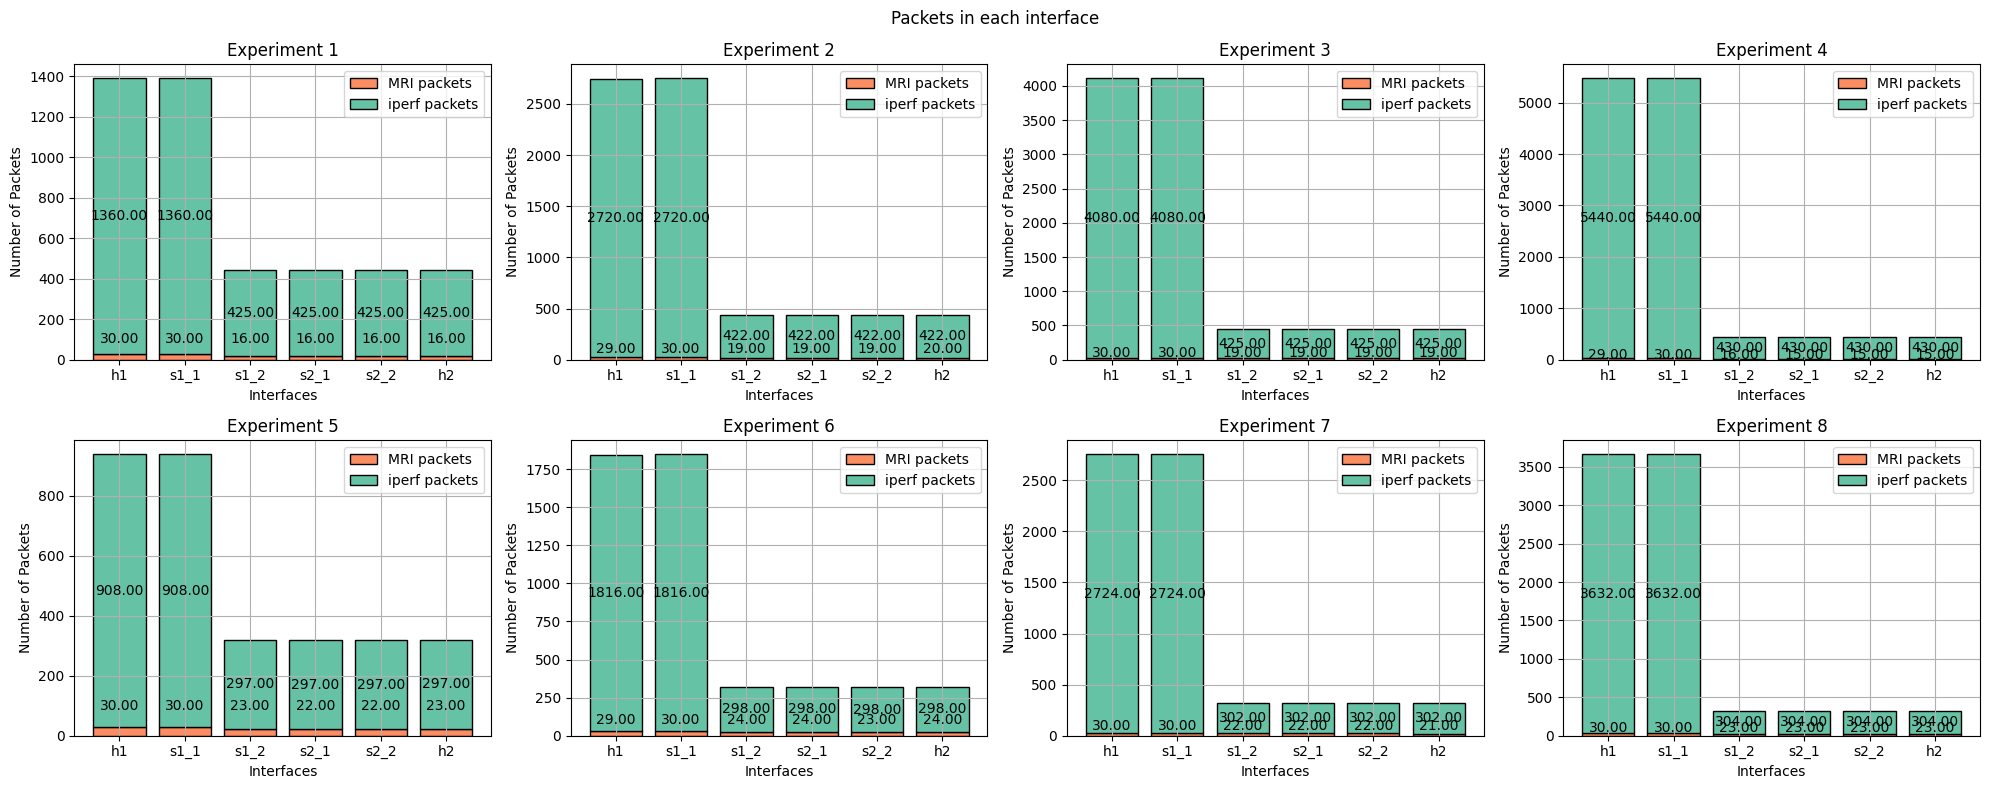

In [17]:
import pandas as pd
import matplotlib.pyplot as plt


plt.figure(figsize=(20, 8))
for experiment in range(1, 9):
    file_path = f'./graphs/data/exp1{experiment}_nH.csv'
    dfh = pd.read_csv(file_path)
    
    file_path = f'./graphs/data/exp1{experiment}_nS1.csv'
    dfs1 = pd.read_csv(file_path)
    
    file_path = f'./graphs/data/exp1{experiment}_nS2.csv'
    dfs2 = pd.read_csv(file_path)
    
    h1_MRI = dfh.iloc[0]['h1_MRI']
    h1_iperf = dfh.iloc[0]['h1_iperf']
    h2_MRI = dfh.iloc[0]['h2_MRI']
    h2_iperf = dfh.iloc[0]['h2_iperf']
    
    s1_1_MRI = dfs1.iloc[0]['s11_MRI']
    s1_1_iperf = dfs1.iloc[0]['s11_iperf']
    s1_2_MRI = dfs1.iloc[0]['s12_MRI']
    s1_2_iperf = dfs1.iloc[0]['s12_iperf']
    
    s2_1_MRI = dfs2.iloc[0]['s21_MRI']
    s2_1_iperf = dfs2.iloc[0]['s21_iperf']
    s2_2_MRI = dfs2.iloc[0]['s22_MRI']
    s2_2_iperf = dfs2.iloc[0]['s22_iperf']

    plt.subplot(2, 4, experiment)
    labels = ["MRI packets", "iperf packets"]
    legend_labels = set()
    cmap = plt.get_cmap('Set2')
    colors = [ cmap(1), cmap(0)]

    bottom = 0
    for packets, label, color in zip([h1_MRI, h1_iperf], labels, colors):
        bar = plt.bar(1, packets, bottom=bottom, color=color, edgecolor='black')
        if label == "MRI packets":
            plt.text(1, bottom + 100, f'{packets:.2f}', ha='center', va='center', color='black')
        if label == "iperf packets":
            plt.text(1, bottom + packets / 2, f'{packets:.2f}', ha='center', va='center', color='black')
        if label not in legend_labels:
            legend_labels.add(label)
            bar.set_label(label)
        bottom += packets
    
    bottom = 0
    for packets, label, color in zip([s1_1_MRI, s1_1_iperf], labels, colors):
        bar = plt.bar(2, packets, bottom=bottom, color=color, edgecolor='black')
        if label == "MRI packets":
            plt.text(2, bottom + 100, f'{packets:.2f}', ha='center', va='center', color='black')
        if label == "iperf packets":
            plt.text(2, bottom + packets / 2, f'{packets:.2f}', ha='center', va='center', color='black')
        if label not in legend_labels:
            legend_labels.add(label)
            bar.set_label(label)
        bottom += packets
    
    bottom = 0
    for packets, label, color in zip([s1_2_MRI, s1_2_iperf], labels, colors):
        bar = plt.bar(3, packets, bottom=bottom, color=color, edgecolor='black')
        if label == "MRI packets":
            plt.text(3, bottom + 100, f'{packets:.2f}', ha='center', va='center', color='black')
        if label == "iperf packets":
            plt.text(3, bottom + packets / 2, f'{packets:.2f}', ha='center', va='center', color='black')
        if label not in legend_labels:
            legend_labels.add(label)
            bar.set_label(label)
        bottom += packets
    
    bottom = 0
    for packets, label, color in zip([s2_1_MRI, s2_1_iperf], labels, colors):
        bar = plt.bar(4, packets, bottom=bottom, color=color, edgecolor='black')
        if label == "MRI packets":
            plt.text(4, bottom + 100, f'{packets:.2f}', ha='center', va='center', color='black')
        if label == "iperf packets":
            plt.text(4, bottom + packets / 2, f'{packets:.2f}', ha='center', va='center', color='black')
        if label not in legend_labels:
            legend_labels.add(label)
            bar.set_label(label)
        bottom += packets
    
    bottom = 0
    for packets, label, color in zip([s2_2_MRI, s2_2_iperf], labels, colors):
        bar = plt.bar(5, packets, bottom=bottom, color=color, edgecolor='black')
        if label == "MRI packets":
            plt.text(5, bottom + 100, f'{packets:.2f}', ha='center', va='center', color='black')
        if label == "iperf packets":
            plt.text(5, bottom + packets / 2, f'{packets:.2f}', ha='center', va='center', color='black')
        if label not in legend_labels:
            legend_labels.add(label)
            bar.set_label(label)
        bottom += packets
    
    bottom = 0
    for packets, label, color in zip([h2_MRI, h2_iperf], labels, colors):
        bar = plt.bar(6, packets, bottom=bottom, color=color, edgecolor='black')
        if label == "MRI packets":
            plt.text(6, bottom + 100, f'{packets:.2f}', ha='center', va='center', color='black')
        if label == "iperf packets":
            plt.text(6, bottom + packets / 2, f'{packets:.2f}', ha='center', va='center', color='black')
        if label not in legend_labels:
            legend_labels.add(label)
            bar.set_label(label)
        bottom += packets
    
    plt.xticks([1, 2, 3, 4, 5, 6], ['h1', 's1_1', 's1_2', 's2_1', 's2_2', 'h2'])
    plt.ylabel('Number of Packets')
    plt.xlabel('Interfaces')
    plt.title(f'Experiment {experiment}')
    plt.legend()
    plt.grid(True)


plt.suptitle('Packets in each interface')
plt.tight_layout()
plt.savefig('./graphs/figures/nP_exp10.png')
plt.show()

## Experiments 21-28 graphs

### Bandwidth

In [18]:
experiments = {"exp21" : None, "exp22" : None, "exp23" : None, "exp24" : None, "exp25" : None, "exp26" : None, "exp27" : None, "exp28" : None}
for experiment in experiments:
    with open(f'./graphs/data/{experiment}.json') as f:
        data = json.load(f)
    intervals = data['intervals']
    times = []

    for i in range(30):
        times.append(i+1)

    iperf_bandwidth = []

    for i in range(5):
        iperf_bandwidth.append(0)

    for interval in enumerate(intervals):
        iperf_bandwidth.append(interval[1]['sum']['bits_per_second'])

    n = 10 if experiment == 'exp21' or experiment == 'exp22' or experiment == 'exp23' or experiment == 'exp24' else 15
    for i in range(n):
        iperf_bandwidth.append(0)
    data = {
        'times': times,
        'iperf_bandwidth': iperf_bandwidth,
    }
    experiments[experiment] =  pd.DataFrame(data)
    
MRI_bandwidth = []
for i in range(30):
    MRI_bandwidth.append(544)

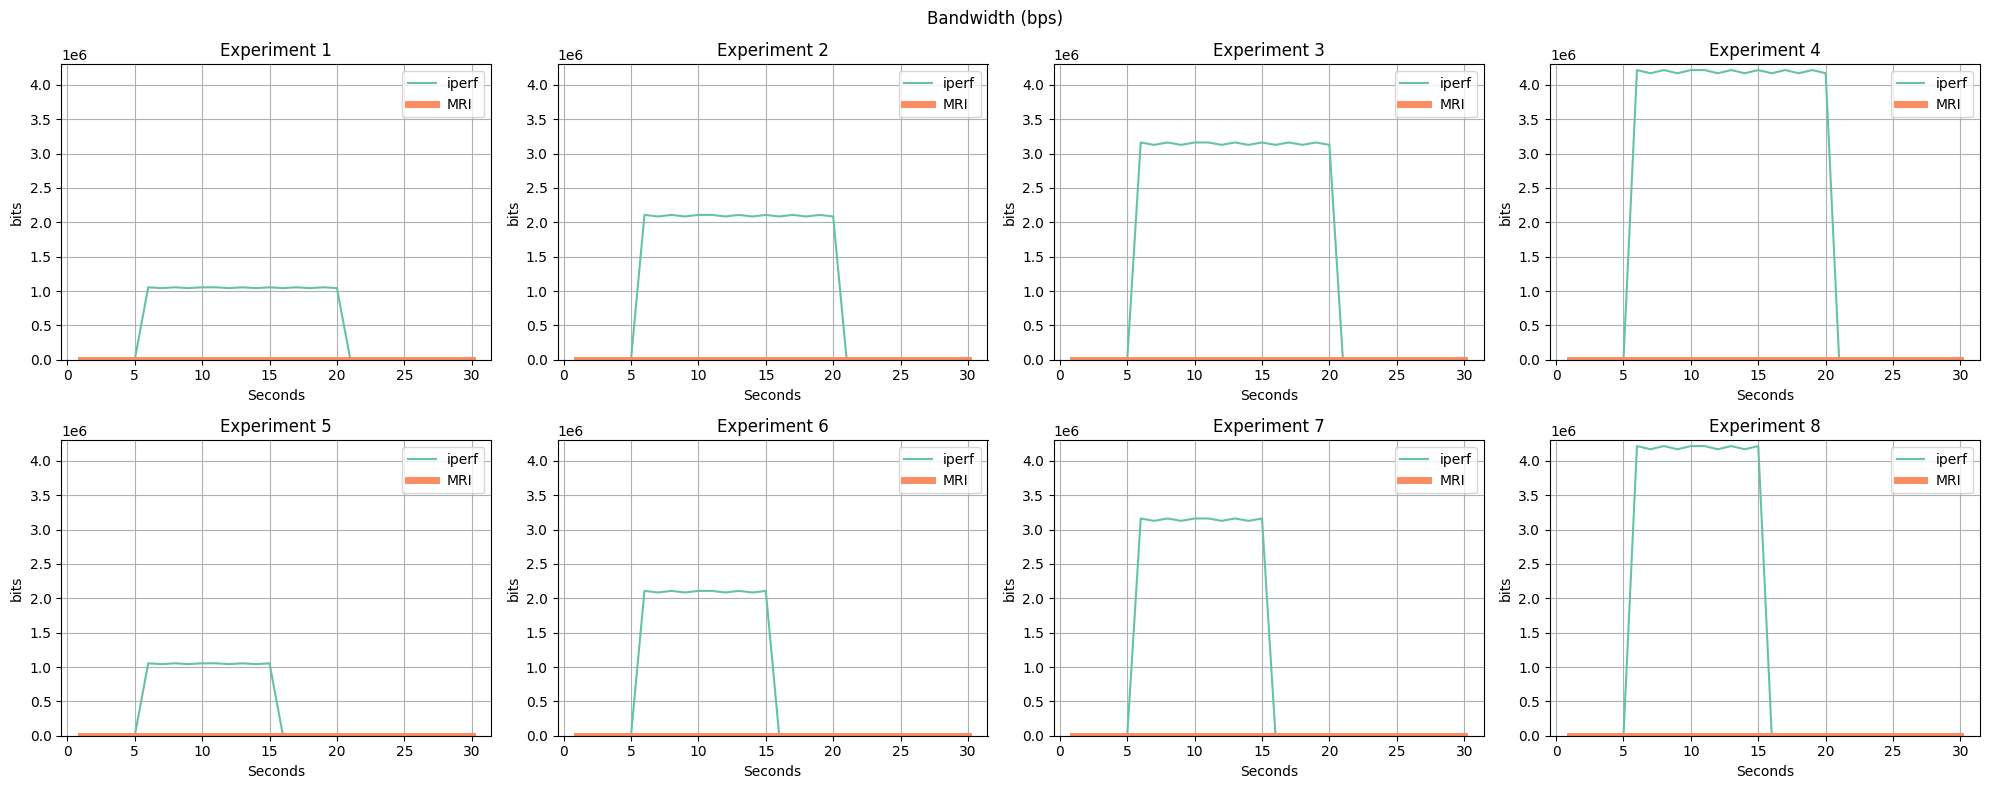

In [19]:
plt.figure(figsize=(20, 8))

for n in range(1,9):
    plt.subplot(2,4,n)
    result_df = experiments[f"exp2{n}"]
    plt.plot(result_df["times"], result_df["iperf_bandwidth"], linestyle='-', color=cmap(0),label="iperf")
    plt.plot(result_df["times"], MRI_bandwidth, linestyle='-', color=cmap(1), linewidth=5,label="MRI") 
    plt.title(f'Experiment {n}')
    plt.xlabel('Seconds')
    plt.ylabel('bits')
    plt.ylim([0, 4.3e6])
    plt.legend()
    plt.grid(True)

plt.suptitle('Bandwidth (bps)')
plt.tight_layout()
plt.savefig('./graphs/figures/BW_exp20.png')
plt.show()

### Number of packets in the buffer of each switch

In [20]:
experiments = {"exp21" : None, "exp22" : None, "exp23" : None, "exp24" : None, "exp25" : None, "exp26" : None, "exp27" : None, "exp28" : None}
max_buffer1 = 200
max_buffer2 = 100

for experiment in experiments:
    df = pd.read_csv(f'./graphs/data/{experiment}.csv')
    hex_list = df['Values'].tolist()
    packet_numbers = [int(packet[-2:], 16) for packet in hex_list]
    max_value = max(packet_numbers)
    sorted_array = [-1] * (max_value + 1)
    for number in packet_numbers:
        sorted_array[number] = number
    qdepth_values_swid_1 = [max_buffer1 if x == -1 else None for x in sorted_array]
    #qdepth_values_swid_2 = [None for x in sorted_array]
    #qdepth_values_swid_2 = [0 if x == -1 else None for x in sorted_array]
    qdepth_values_swid_2 = [max_buffer2 if x == -1 else None for x in sorted_array]
    for index, pkt in enumerate(hex_list):
        if sorted_array[int(pkt[-2:], 16)] != -1:
            packet_bytes = bytes.fromhex(pkt)
            packet_reconstructed = Ether(packet_bytes)
            mri_layer = packet_reconstructed.getlayer(IPOption_MRI)
            qdepth_value_swid_1 = None
            qdepth_value_swid_2 = None
            if mri_layer:
                for sw_trace in mri_layer.swtraces:
                    if sw_trace.swid == 1:
                        qdepth_value_swid_1 = sw_trace.qdepth
                    elif sw_trace.swid == 2:
                        qdepth_value_swid_2 = sw_trace.qdepth
    
            if qdepth_value_swid_1 is not None:
                qdepth_values_swid_1[int(pkt[-2:], 16)] = qdepth_value_swid_1
            #if qdepth_value_swid_2 is not None:
                qdepth_values_swid_2[int(pkt[-2:], 16)] = qdepth_value_swid_2
    data = {
        'QDepth_SWID_1': qdepth_values_swid_1,
        'QDepth_SWID_2': qdepth_values_swid_2,
        'sorted_array': sorted_array,
    }
    
    experiments[experiment] =  pd.DataFrame(data)

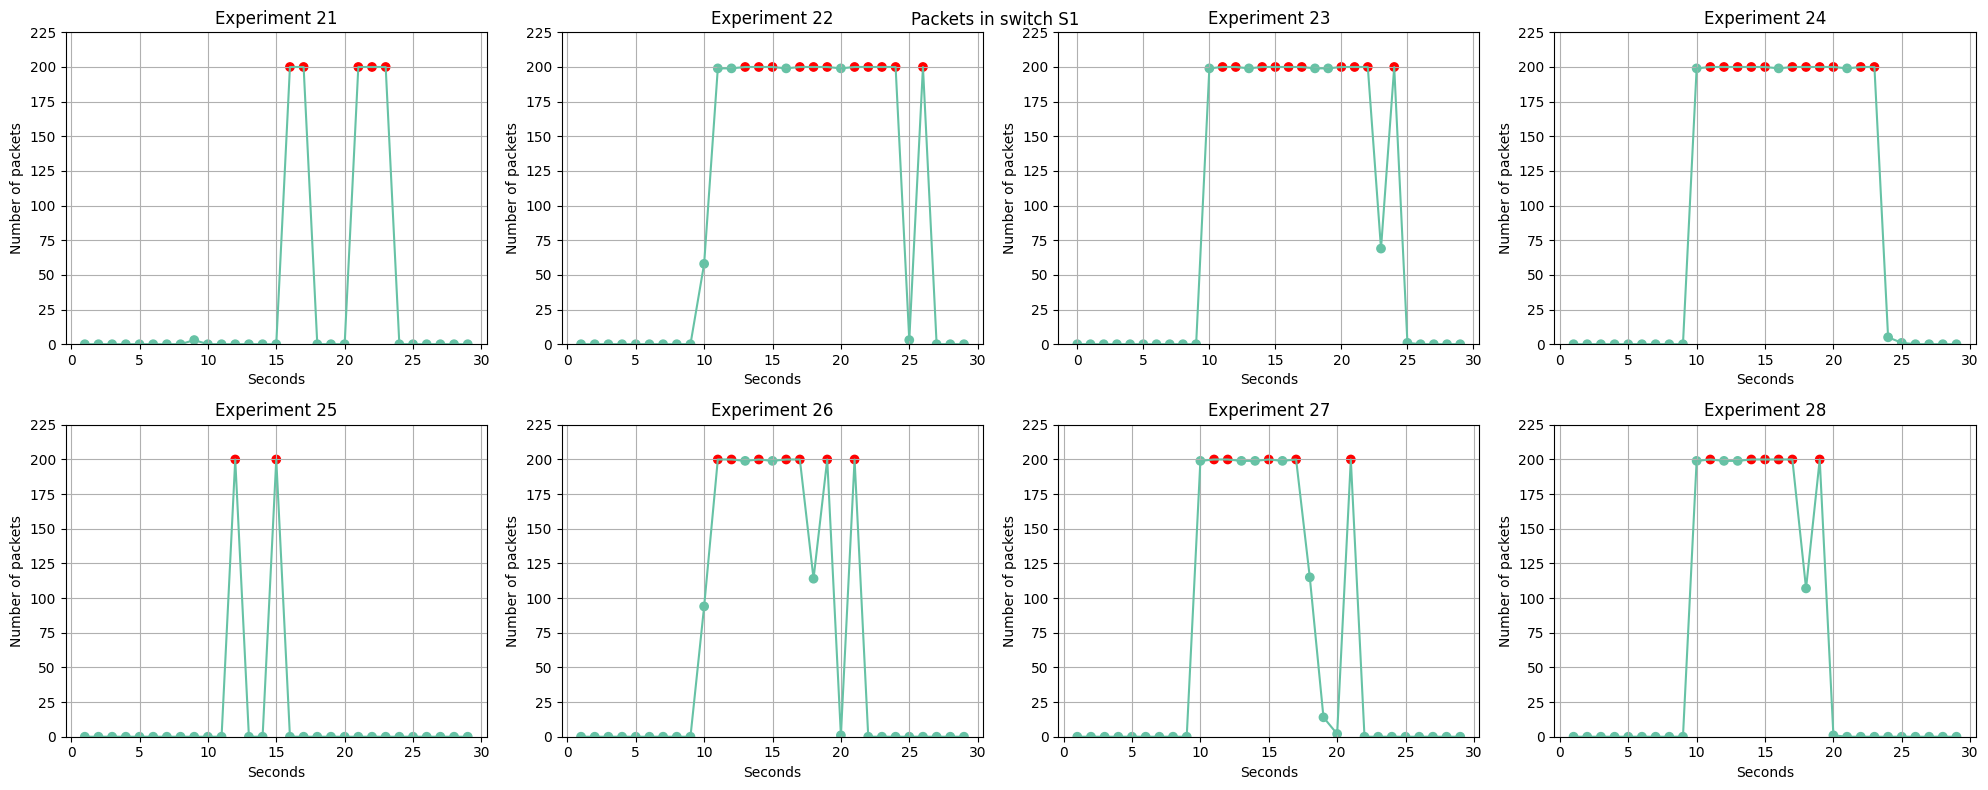

In [21]:
plt.figure(figsize=(20, 8))
swidSwitch = "QDepth_SWID_1"

plt.subplot(2,4,1)
result_df = experiments["exp21"][1:]
colors = ["red" if val == -1 else cmap(0) for val in result_df['sorted_array']]
packet_numbers = result_df.index
plt.plot(packet_numbers, result_df[f'{swidSwitch}'], label=f'{swidSwitch}',color=cmap(0))
plt.scatter(packet_numbers, result_df[f'{swidSwitch}'], c=colors, label=f'{swidSwitch}', marker='o')
plt.xlabel('Seconds')
plt.ylabel('Number of packets')
plt.title('Experiment 21')
plt.ylim([0, int(max_buffer1)+25])
plt.grid(True)

plt.subplot(2,4,2)
result_df = experiments["exp22"][1:]
colors = ["red" if val == -1 else cmap(0) for val in result_df['sorted_array']]
packet_numbers = result_df.index
plt.scatter(packet_numbers, result_df[f'{swidSwitch}'], c=colors, label=f'{swidSwitch}', marker='o')
plt.plot(packet_numbers, result_df[f'{swidSwitch}'], label=f'{swidSwitch}',color=cmap(0))
plt.xlabel('Seconds')
plt.ylabel('Number of packets')
plt.title('Experiment 22')
plt.ylim([0, int(max_buffer1)+25])
plt.grid(True)

plt.subplot(2,4,3)
result_df = experiments["exp23"]
colors = ["red" if val == -1 else cmap(0) for val in result_df['sorted_array']]
packet_numbers = result_df.index
plt.scatter(packet_numbers, result_df[f'{swidSwitch}'], c=colors, label=f'{swidSwitch}', marker='o')
plt.plot(packet_numbers, result_df[f'{swidSwitch}'], label=f'{swidSwitch}',color=cmap(0))
plt.xlabel('Seconds')
plt.ylabel('Number of packets')
plt.title('Experiment 23')
plt.ylim([0, int(max_buffer1)+25])
plt.grid(True)

plt.subplot(2,4,4)
result_df = experiments["exp24"][1:]
colors = ["red" if val == -1 else cmap(0) for val in result_df['sorted_array']]
packet_numbers = result_df.index
plt.scatter(packet_numbers, result_df[f'{swidSwitch}'], c=colors, label=f'{swidSwitch}', marker='o')
plt.plot(packet_numbers, result_df[f'{swidSwitch}'], label=f'{swidSwitch}',color=cmap(0))
plt.xlabel('Seconds')
plt.ylabel('Number of packets')
plt.title('Experiment 24')
plt.ylim([0, int(max_buffer1)+25])
plt.grid(True)

plt.subplot(2,4,5)
result_df = experiments["exp25"][1:]
colors = ["red" if val == -1 else cmap(0) for val in result_df['sorted_array']]
packet_numbers = result_df.index
plt.scatter(packet_numbers, result_df[f'{swidSwitch}'], c=colors, label=f'{swidSwitch}', marker='o')
plt.plot(packet_numbers, result_df[f'{swidSwitch}'], label=f'{swidSwitch}',color=cmap(0))
plt.xlabel('Seconds')
plt.ylabel('Number of packets')
plt.title('Experiment 25')
plt.ylim([0, int(max_buffer1)+25])
plt.grid(True)

plt.subplot(2,4,6)
result_df = experiments["exp26"][1:]
colors = ["red" if val == -1 else cmap(0) for val in result_df['sorted_array']]
packet_numbers = result_df.index
plt.scatter(packet_numbers, result_df[f'{swidSwitch}'], c=colors, label=f'{swidSwitch}', marker='o')
plt.plot(packet_numbers, result_df[f'{swidSwitch}'], label=f'{swidSwitch}',color=cmap(0))
plt.xlabel('Seconds')
plt.ylabel('Number of packets')
plt.title('Experiment 26')
plt.ylim([0, int(max_buffer1)+25])
plt.grid(True)

plt.subplot(2,4,7)
result_df = experiments["exp27"][1:]
colors = ["red" if val == -1 else cmap(0) for val in result_df['sorted_array']]
packet_numbers = result_df.index
plt.scatter(packet_numbers, result_df[f'{swidSwitch}'], c=colors, label=f'{swidSwitch}', marker='o')
plt.plot(packet_numbers, result_df[f'{swidSwitch}'], label=f'{swidSwitch}',color=cmap(0))
plt.xlabel('Seconds')
plt.ylabel('Number of packets')
plt.title('Experiment 27')
plt.ylim([0, int(max_buffer1)+25])
plt.grid(True)

plt.subplot(2,4,8)
result_df = experiments["exp28"][1:]
colors = ["red" if val == -1 else cmap(0) for val in result_df['sorted_array']]
packet_numbers = result_df.index
plt.scatter(packet_numbers, result_df[f'{swidSwitch}'], c=colors, label=f'{swidSwitch}', marker='o')
plt.plot(packet_numbers, result_df[f'{swidSwitch}'], label=f'{swidSwitch}',color=cmap(0))
plt.xlabel('Seconds')
plt.ylabel('Number of packets')
plt.title('Experiment 28')
plt.ylim([0, int(max_buffer1)+25])
plt.grid(True)

plt.tight_layout()

plt.suptitle('Packets in switch S1')
plt.savefig('./graphs/figures/QDepth_exp20_S1.png')
plt.show()

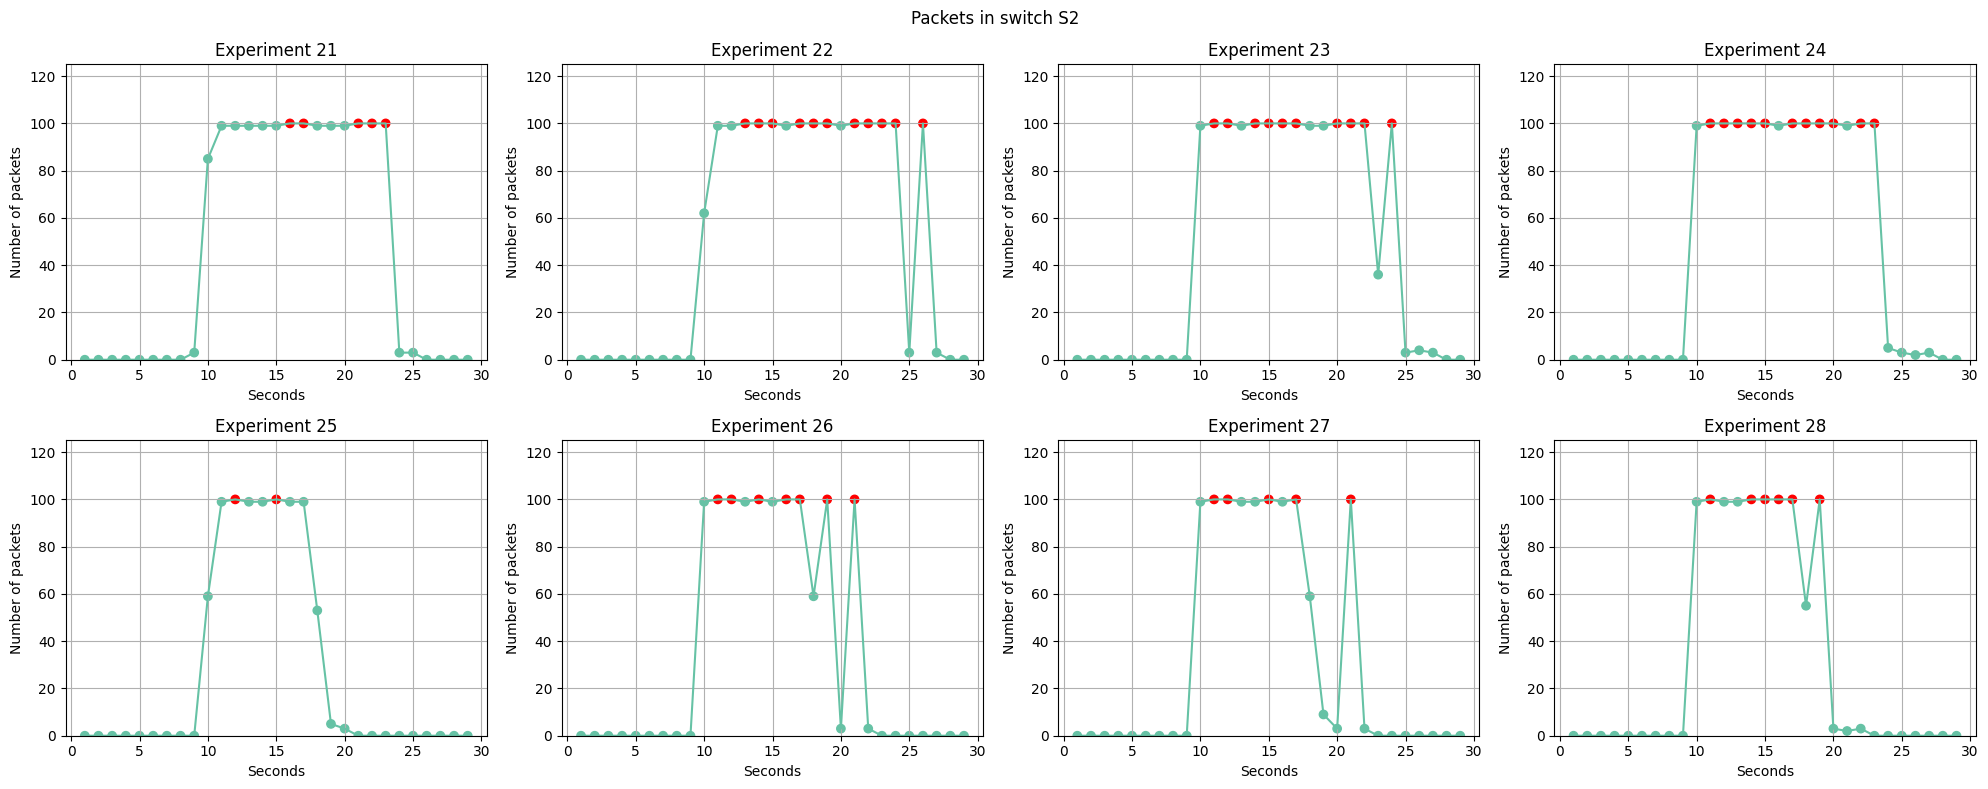

In [22]:
plt.figure(figsize=(20, 8))
swidSwitch = "QDepth_SWID_2"

plt.subplot(2,4,1)
result_df = experiments["exp21"][1:]
colors = ["red" if val == -1 else cmap(0) for val in result_df['sorted_array']]
packet_numbers = result_df.index
plt.plot(packet_numbers, result_df[f'{swidSwitch}'], label=f'{swidSwitch}',color=cmap(0))
plt.scatter(packet_numbers, result_df[f'{swidSwitch}'], c=colors, label=f'{swidSwitch}', marker='o')

plt.xlabel('Seconds')
plt.ylabel('Number of packets')
plt.title('Experiment 21')
plt.ylim([0, int(max_buffer2)+25])
plt.grid(True)

plt.subplot(2,4,2)
result_df = experiments["exp22"][1:]
colors = ["red" if val == -1 else cmap(0) for val in result_df['sorted_array']]
packet_numbers = result_df.index
plt.scatter(packet_numbers, result_df[f'{swidSwitch}'], c=colors, label=f'{swidSwitch}', marker='o')
plt.plot(packet_numbers, result_df[f'{swidSwitch}'], label=f'{swidSwitch}',color=cmap(0))
plt.xlabel('Seconds')
plt.ylabel('Number of packets')
plt.title('Experiment 22')
plt.ylim([0, int(max_buffer2)+25])
plt.grid(True)

plt.subplot(2,4,3)
result_df = experiments["exp23"][1:]
colors = ["red" if val == -1 else cmap(0) for val in result_df['sorted_array']]
packet_numbers = result_df.index
plt.scatter(packet_numbers, result_df[f'{swidSwitch}'], c=colors, label=f'{swidSwitch}', marker='o')
plt.plot(packet_numbers, result_df[f'{swidSwitch}'], label=f'{swidSwitch}',color=cmap(0))
plt.xlabel('Seconds')
plt.ylabel('Number of packets')
plt.title('Experiment 23')
plt.ylim([0, int(max_buffer2)+25])
plt.grid(True)

plt.subplot(2,4,4)
result_df = experiments["exp24"][1:]
colors = ["red" if val == -1 else cmap(0) for val in result_df['sorted_array']]
packet_numbers = result_df.index
plt.scatter(packet_numbers, result_df[f'{swidSwitch}'], c=colors, label=f'{swidSwitch}', marker='o')
plt.plot(packet_numbers, result_df[f'{swidSwitch}'], label=f'{swidSwitch}',color=cmap(0))
plt.xlabel('Seconds')
plt.ylabel('Number of packets')
plt.title('Experiment 24')
plt.ylim([0, int(max_buffer2)+25])
plt.grid(True)

plt.subplot(2,4,5)
result_df = experiments["exp25"][1:]
colors = ["red" if val == -1 else cmap(0) for val in result_df['sorted_array']]
packet_numbers = result_df.index
plt.scatter(packet_numbers, result_df[f'{swidSwitch}'], c=colors, label=f'{swidSwitch}', marker='o')
plt.plot(packet_numbers, result_df[f'{swidSwitch}'], label=f'{swidSwitch}',color=cmap(0))
plt.xlabel('Seconds')
plt.ylabel('Number of packets')
plt.title('Experiment 25')
plt.ylim([0, int(max_buffer2)+25])
plt.grid(True)

plt.subplot(2,4,6)
result_df = experiments["exp26"][1:]
colors = ["red" if val == -1 else cmap(0) for val in result_df['sorted_array']]
packet_numbers = result_df.index
plt.scatter(packet_numbers, result_df[f'{swidSwitch}'], c=colors, label=f'{swidSwitch}', marker='o')
plt.plot(packet_numbers, result_df[f'{swidSwitch}'], label=f'{swidSwitch}',color=cmap(0))
plt.xlabel('Seconds')
plt.ylabel('Number of packets')
plt.title('Experiment 26')
plt.ylim([0, int(max_buffer2)+25])
plt.grid(True)

plt.subplot(2,4,7)
result_df = experiments["exp27"][1:]
colors = ["red" if val == -1 else cmap(0) for val in result_df['sorted_array']]
packet_numbers = result_df.index
plt.scatter(packet_numbers, result_df[f'{swidSwitch}'], c=colors, label=f'{swidSwitch}', marker='o')
plt.plot(packet_numbers, result_df[f'{swidSwitch}'], label=f'{swidSwitch}',color=cmap(0))
plt.xlabel('Seconds')
plt.ylabel('Number of packets')
plt.title('Experiment 27')
plt.ylim([0, int(max_buffer2)+25])
plt.grid(True)

plt.subplot(2,4,8)
result_df = experiments["exp28"][1:]
colors = ["red" if val == -1 else cmap(0) for val in result_df['sorted_array']]
packet_numbers = result_df.index
plt.scatter(packet_numbers, result_df[f'{swidSwitch}'], c=colors, label=f'{swidSwitch}', marker='o')
plt.plot(packet_numbers, result_df[f'{swidSwitch}'], label=f'{swidSwitch}',color=cmap(0))
plt.xlabel('Seconds')
plt.ylabel('Number of packets')
plt.title('Experiment 28')
plt.ylim([0, int(max_buffer2)+25])
plt.grid(True)


plt.suptitle('Packets in switch S2')
plt.tight_layout()
plt.savefig('./graphs/figures/QDepth_exp20_S2.png')
plt.show()

### Lost Packets per thread

In [23]:
experiments = {"exp21" : None, "exp22" : None, "exp23" : None, "exp24" : None, "exp25" : None, "exp26" : None, "exp27" : None, "exp28" : None}
for experiment in experiments:
    with open(f'./graphs/data/{experiment}.json') as f:
        data = json.load(f)
    streams = data['end']['streams']
    lost_packets = []
    packets = []
    for i, streams in enumerate(streams):
        lost_packets.append(streams['udp']['lost_packets'])
        packets.append(streams['udp']['packets'])
    data = {
        'lost_packets': lost_packets,
        'packets': packets
    }
    experiments[experiment] =  pd.DataFrame(data)

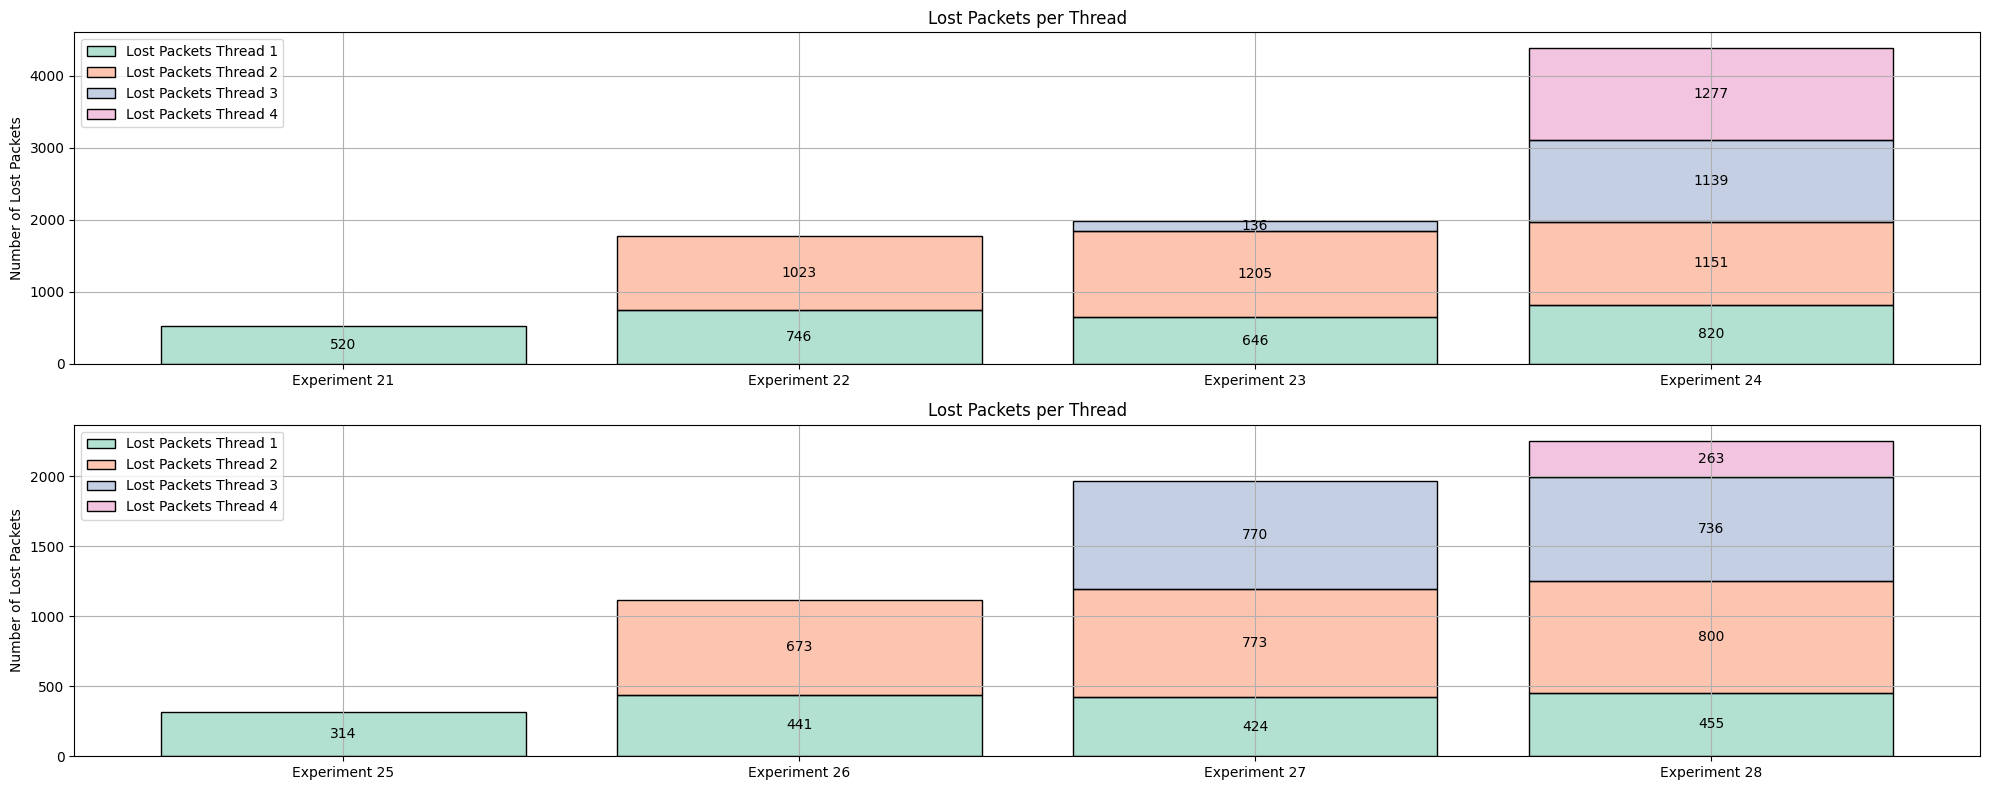

In [24]:
def add_alpha(color, alpha=0.7):
    try:
        c = mcolors.cnames[color]
    except:
        c = color
    c = mcolors.to_rgba(c)
    return (c[0], c[1], c[2], alpha)

cmap = plt.get_cmap('Set2')
plt.figure(figsize=(20, 8))

plt.subplot(2, 1, 1)
legend_labels = set()
for i in range(1, 5):
    df = experiments[f"exp2{i}"]
    lost_packets = df['lost_packets']
    total_packets = df['packets'].sum()
    labels = [f'Lost Packets Thread {j+1}' for j in range(len(lost_packets))]
    colors = [add_alpha(cmap(j), 0.5) for j in range(len(lost_packets))]
    bottom = 0
    for lost, label, color in zip(lost_packets, labels, colors):
        percentage = (lost / total_packets) * 100
        bar = plt.bar(i, lost, bottom=bottom, color=color, edgecolor='black')
        plt.text(i, bottom + lost / 2, f'{lost}', ha='center', va='center', color='black')
        if label not in legend_labels:
            legend_labels.add(label)
            bar.set_label(label)
        bottom += lost

plt.xticks(range(1, 5), [f'Experiment 2{i}' for i in range(1, 5)])
plt.ylabel('Number of Lost Packets')
plt.title('Lost Packets per Thread')
plt.legend()
plt.grid(True)

legend_labels = set()
plt.subplot(2, 1, 2)
for i in range(5, 9):
    df = experiments[f"exp2{i}"]
    lost_packets = df['lost_packets']
    total_packets = df['packets'].sum()
    labels = [f'Lost Packets Thread {j+1}' for j in range(len(lost_packets))]
    colors = [add_alpha(cmap(j), 0.5) for j in range(len(lost_packets))]
    bottom = 0
    for lost, label, color in zip(lost_packets, labels, colors):
        percentage = (lost / total_packets) * 100
        bar = plt.bar(i, lost, bottom=bottom, color=color, edgecolor='black')
        plt.text(i, bottom + lost / 2, f'{lost}', ha='center', va='center', color='black')
        if label not in legend_labels:
            legend_labels.add(label)
            bar.set_label(label)
        bottom += lost

plt.xticks(range(5,9), [f'Experiment 2{i}' for i in range(5, 9)])
plt.ylabel('Number of Lost Packets')
plt.title('Lost Packets per Thread')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('./graphs/figures/LP_exp20.png')
plt.show()

### Number of packets in each interface

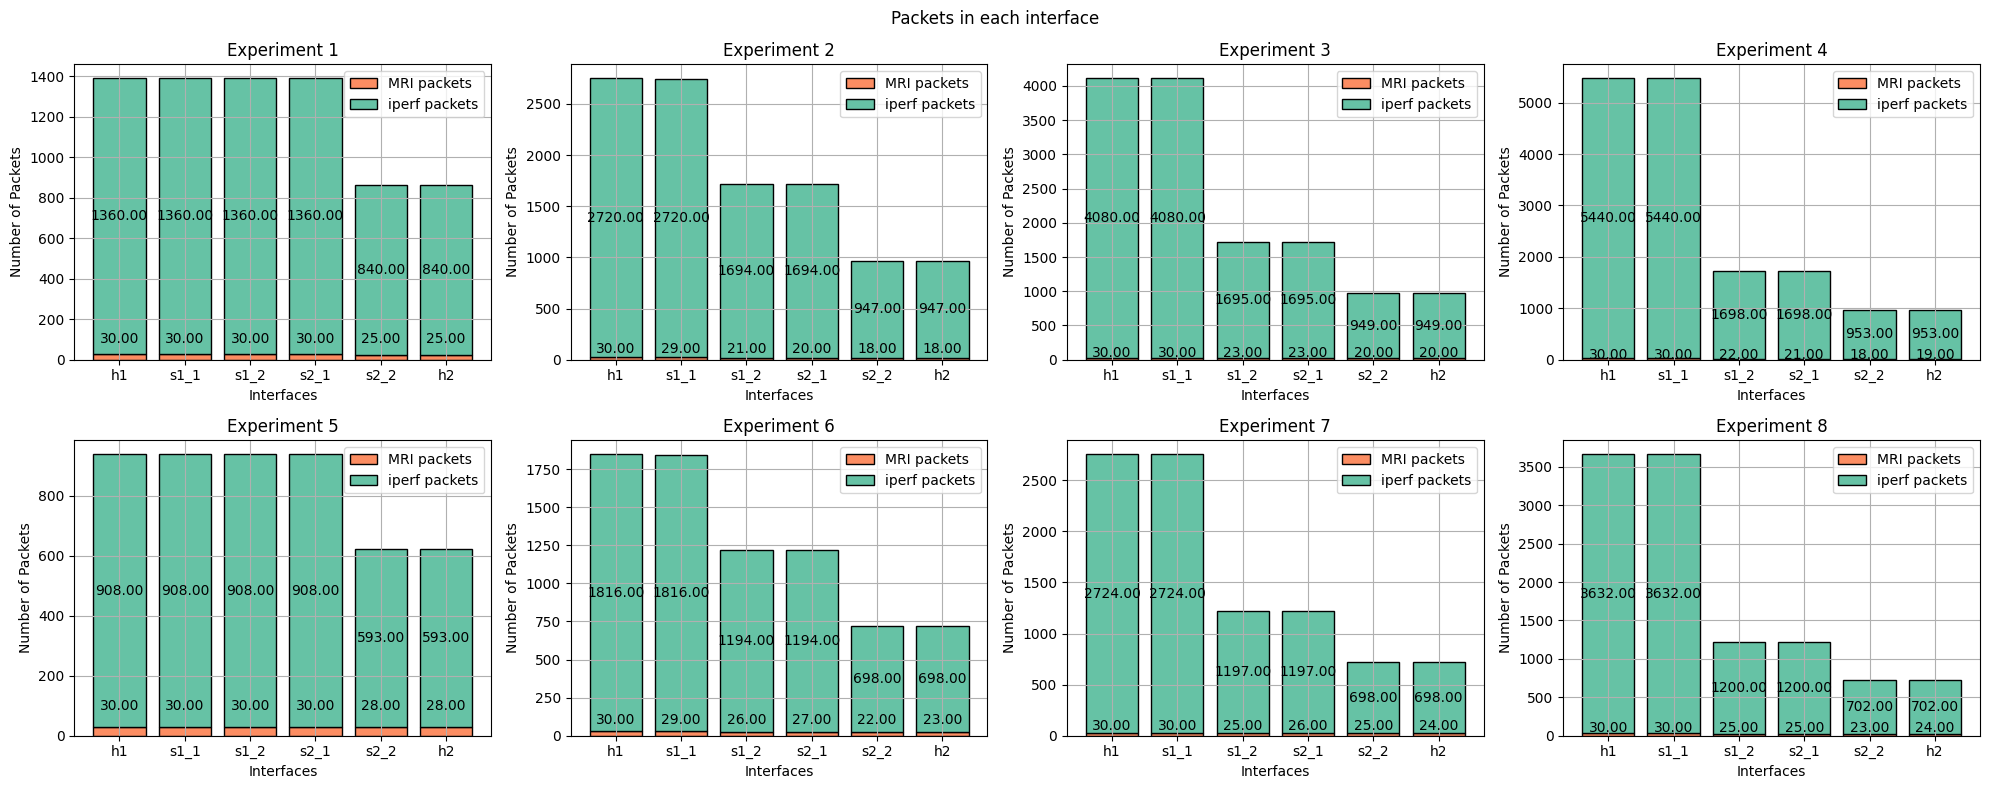

In [25]:
import pandas as pd
import matplotlib.pyplot as plt


plt.figure(figsize=(20, 8))
for experiment in range(1, 9):
    file_path = f'./graphs/data/exp2{experiment}_nH.csv'
    dfh = pd.read_csv(file_path)
    
    file_path = f'./graphs/data/exp2{experiment}_nS1.csv'
    dfs1 = pd.read_csv(file_path)
    
    file_path = f'./graphs/data/exp2{experiment}_nS2.csv'
    dfs2 = pd.read_csv(file_path)
    
    h1_MRI = dfh.iloc[0]['h1_MRI']
    h1_iperf = dfh.iloc[0]['h1_iperf']
    h2_MRI = dfh.iloc[0]['h2_MRI']
    h2_iperf = dfh.iloc[0]['h2_iperf']
    
    s1_1_MRI = dfs1.iloc[0]['s11_MRI']
    s1_1_iperf = dfs1.iloc[0]['s11_iperf']
    s1_2_MRI = dfs1.iloc[0]['s12_MRI']
    s1_2_iperf = dfs1.iloc[0]['s12_iperf']
    
    s2_1_MRI = dfs2.iloc[0]['s21_MRI']
    s2_1_iperf = dfs2.iloc[0]['s21_iperf']
    s2_2_MRI = dfs2.iloc[0]['s22_MRI']
    s2_2_iperf = dfs2.iloc[0]['s22_iperf']

    plt.subplot(2, 4, experiment)
    labels = ["MRI packets", "iperf packets"]
    legend_labels = set()
    cmap = plt.get_cmap('Set2')
    colors = [ cmap(1), cmap(0)]

    bottom = 0
    for packets, label, color in zip([h1_MRI, h1_iperf], labels, colors):
        bar = plt.bar(1, packets, bottom=bottom, color=color, edgecolor='black')
        if label == "MRI packets":
            plt.text(1, bottom + 100, f'{packets:.2f}', ha='center', va='center', color='black')
        if label == "iperf packets":
            plt.text(1, bottom + packets / 2, f'{packets:.2f}', ha='center', va='center', color='black')
        if label not in legend_labels:
            legend_labels.add(label)
            bar.set_label(label)
        bottom += packets
    
    bottom = 0
    for packets, label, color in zip([s1_1_MRI, s1_1_iperf], labels, colors):
        bar = plt.bar(2, packets, bottom=bottom, color=color, edgecolor='black')
        if label == "MRI packets":
            plt.text(2, bottom + 100, f'{packets:.2f}', ha='center', va='center', color='black')
        if label == "iperf packets":
            plt.text(2, bottom + packets / 2, f'{packets:.2f}', ha='center', va='center', color='black')
        if label not in legend_labels:
            legend_labels.add(label)
            bar.set_label(label)
        bottom += packets
    
    bottom = 0
    for packets, label, color in zip([s1_2_MRI, s1_2_iperf], labels, colors):
        bar = plt.bar(3, packets, bottom=bottom, color=color, edgecolor='black')
        if label == "MRI packets":
            plt.text(3, bottom + 100, f'{packets:.2f}', ha='center', va='center', color='black')
        if label == "iperf packets":
            plt.text(3, bottom + packets / 2, f'{packets:.2f}', ha='center', va='center', color='black')
        if label not in legend_labels:
            legend_labels.add(label)
            bar.set_label(label)
        bottom += packets
    
    bottom = 0
    for packets, label, color in zip([s2_1_MRI, s2_1_iperf], labels, colors):
        bar = plt.bar(4, packets, bottom=bottom, color=color, edgecolor='black')
        if label == "MRI packets":
            plt.text(4, bottom + 100, f'{packets:.2f}', ha='center', va='center', color='black')
        if label == "iperf packets":
            plt.text(4, bottom + packets / 2, f'{packets:.2f}', ha='center', va='center', color='black')
        if label not in legend_labels:
            legend_labels.add(label)
            bar.set_label(label)
        bottom += packets
    
    bottom = 0
    for packets, label, color in zip([s2_2_MRI, s2_2_iperf], labels, colors):
        bar = plt.bar(5, packets, bottom=bottom, color=color, edgecolor='black')
        if label == "MRI packets":
            plt.text(5, bottom + 100, f'{packets:.2f}', ha='center', va='center', color='black')
        if label == "iperf packets":
            plt.text(5, bottom + packets / 2, f'{packets:.2f}', ha='center', va='center', color='black')
        if label not in legend_labels:
            legend_labels.add(label)
            bar.set_label(label)
        bottom += packets
    
    bottom = 0
    for packets, label, color in zip([h2_MRI, h2_iperf], labels, colors):
        bar = plt.bar(6, packets, bottom=bottom, color=color, edgecolor='black')
        if label == "MRI packets":
            plt.text(6, bottom + 100, f'{packets:.2f}', ha='center', va='center', color='black')
        if label == "iperf packets":
            plt.text(6, bottom + packets / 2, f'{packets:.2f}', ha='center', va='center', color='black')
        if label not in legend_labels:
            legend_labels.add(label)
            bar.set_label(label)
        bottom += packets
    
    plt.xticks([1, 2, 3, 4, 5, 6], ['h1', 's1_1', 's1_2', 's2_1', 's2_2', 'h2'])
    plt.ylabel('Number of Packets')
    plt.xlabel('Interfaces')
    plt.title(f'Experiment {experiment}')
    plt.legend()
    plt.grid(True)


plt.suptitle('Packets in each interface')
plt.tight_layout()
plt.savefig('./graphs/figures/nP_exp20.png')
plt.show()